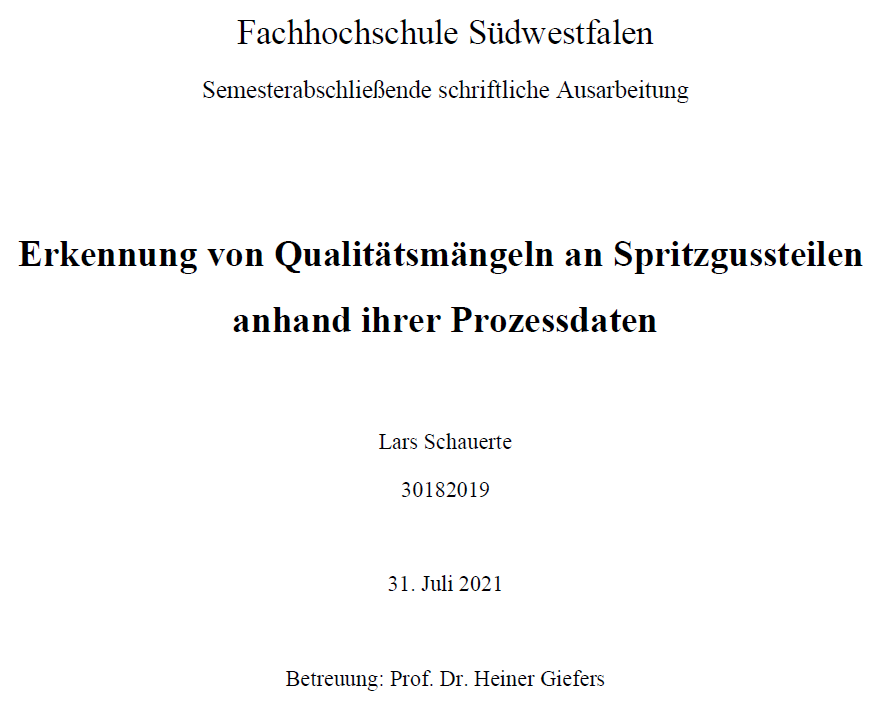

# Kurzfassung

Das Spritzgießen ist ein häufig in der Kunststoffverarbeitung eingesetztes Verfahren und ist deshalb von großer ökologischer und ökonomischer Bedeutung. Ziel dieser Arbeit war es, die üblicherweise von Spritzgussmaschinen bereitgestellten Daten zu nutzen, um Fehlteile – also Teile mit unzulässigen Qualitätsmängeln – unmittelbar zu erkennen und damit aussortieren zu können. Es hat sich gezeigt, dass dies für die untersuchten Qualitätsmängel mit einer Genauigkeit von *98,0 - 99,0 %* unter Anwendung linearer Machine-Learning-Modelle möglich ist. Darüber hinaus konnte gezeigt werden, dass durch die Auswahl repräsentativer Datenpunkte der dafür erforderliche Aufwand beim Labeling auf einen Bruchteil des ursprünglichen Aufwands reduziert werden kann. Diese repräsentative Auswahl erfolgte auf der Basis unüberwachter Clustering-Algorithmen.

# Inhaltsverzeichnis
1. Einleitung
2. Vorbereitung
3. Einführung des vorliegenden Datensatzes
4. Klassifizierung anhand eines Merkmals
5. Klassifizierung anhand mehrerer Merkmale
6. Teilüberwachtes Lernen
7. Ergebnisse und Evaluation
8. Ausblick


# 1\. Einleitung
Das Spritzgießen ist ein Verfahren aus der Kunststoffverarbeitung, um Rohmaterial (Kunststoffgranulat) in eine gewünschte Form zu bringen (sog. Urformverfahren). Technisch handelt es sich dabei um einen komplexen Prozess, dessen Resultat von zahlreichen Variablen abhängt. Aus diesem Grund kommt es hin und wieder vor, dass die gespritzten Teile nicht den Qualitätsstandards eines Herstellers entsprechen und aussortiert werden müssen.

Ziel der vorliegenden Arbeit ist es, diese fehlerhaften Teile anhand der internen Messwerte der Spritzgussmaschine (sog. Prozessdaten) automatisch auszusortieren. Grundlage dafür ist ein Datensatz, welcher in einer vorherigen Hausarbeit [1] erarbeitet wurde. Im Zuge dessen sollen auch Pipelines erarbeitet und Methoden gefunden werden, sodass eine Übertragung der Ergebnisse auf andere Fehler und Produkte erleichtert wird.

Motiviert wird diese Zielsetzung aus verschiedenen Richtungen. Die untersuchten Produkte werden nach ihrer Fertigung vollautomatisch weiterverarbeitet und gehen anschließend direkt in den Verkauf. Es existiert bisher kein System, welches fehlerhafte Teile automatisch aussortiert. Aufgrund der vollautomatischen Abläufe fallen diese Teile auch den Mitarbeitern nicht immer auf und erreichen somit teilweise den Endkunden. Dies sorgt für Unzufriedenheit und unter Umständen einen Imageschaden. Außerdem entsteht sowohl beim Kunden als auch Hersteller ein Mehraufwand für den Austausch des Produkts. Hinzu kommt die zeitliche Verzögerung für den Endkunden.

Des Weiteren sind fehlerhafte und damit unbrauchbare Teile für ein Unternehmen sowohl aus ökologischer als auch ökonomischer Sicht zu vermeiden. Insbesondere für die Fertigungsplanung ist es außerdem wichtig, fehlerhafte Teile unmittelbar zu erkennen, damit die geplante Anzahl an (fehlerfreien) Teilen produziert werden kann. 

Im nachfolgenden Kapitel 3 wird zunächst der vorliegende Datensatz eingeführt. Der Hauptteil beginnt in Kapitel 4 mit dem Versuch, den Datensatz anhand eines einzigen Merkmals linear zu separieren. Im anschließenden Kapitel 5 werden komplexerere Algorithmen untersucht, welche mehrere Merkmale gleichzeitig berücksichtigen können.

Kapitel 6 konzentriert sich darauf, wie die Berücksichtigung weiterer Fehler und Produkte vereinfacht werden kann. Dazu wird der Ansatz des teilüberwachten Lernens verfolgt. Dieser erfordert zunächst eine Dimensionsreduktion der Daten. Anschließend können mit Hilfe von Clustering-Algorithmen repräsentative Datenpunkte ausgewählt und gelabelt werden. Zum Abschluss wird die Qualität der Klassifikatoren untersucht, welche auf daraus resultierenden Daten trainiert wurden.

Im Schlussteil der Arbeit werden die Ergebnisse zusammengefasst und kritisch bewertet. Außerdem wird ein Ausblick gegeben.

# 2\. Vorbereitung

Zunächst müssen einige allgemeine Vorbereitungen getroffen werden, um nachfolgend die Daten verarbeiten zu können. Grundlage dieser Arbeit bildet die Programmiersprache Python und insb. die Module *Numpy*, *Pandas*, *SciKit-Learn* sowie *Matplotlib*.

In [1]:
# Kontrolle der Python-Version
import sys

assert sys.version_info >= (3, 5)

# Import von Scikit-Learn und Kontrolle der Version
import sklearn

assert sklearn.__version__ >= "0.20"

# Weitere Imports
import pandas as pd
import numpy as np
import os

# Imports und Einstellungen um Abbildungen mit matplotlib erzeugen und im
# Notebook darstellen zu können
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Dictionary zur Abspeicherung der Zwischenergebnisse für den Ergebnis-Teil
results = []

Damit die Ausgaben des Notebooks vergleichbar sind wird außerdem der entsprechende Seed gesetzt.

In [2]:
np.random.seed(42)

Im nächsten Schritt kann der Datensatz eingelesen werden. Dieser kann entweder im aktuellen Verzeichnis liegen oder über einen entsprechenden Link aus Google Drive geladen werden.

In [3]:
# Datei via Link aus Google Drive laden
# Alternativ können Sie die Datei 'df.pkl' auch manuell dem aktuellen Unterordner
# hinzufügen
!gdown --id 1r5OzQmxj2TIZUMm3UwKOA-9znGQoe31j

# Daten einlesen
import pickle

with open("df.pkl", "rb") as file:
    df = pickle.load(file)

# Kontrolle
assert len(df.columns) == 107
assert len(df.index) == 4548
print("Anzahl Spalten:", len(df.columns))
print("Anzahl Zeilen:", len(df.index))

Downloading...
From: https://drive.google.com/uc?id=1r5OzQmxj2TIZUMm3UwKOA-9znGQoe31j
To: /content/df.pkl
3.91MB [00:00, 61.7MB/s]
Anzahl Spalten: 107
Anzahl Zeilen: 4548


# 3\. Einführung des vorliegenden Datensatzes

## 3.1 Überblick
Wie bereits in der Einleitung erwähnt, wird in dieser Arbeit ein Datensatz untersucht, welcher in einer vorherigen Hausarbeit [1] erarbeitet wurde.
Er umfasst die nachfolgende Anzahl an Datenpunkten, Merkmalen und Zielwerten:

In [4]:
print("Übersicht")
print("- Anzahl Datenpunkte:", len(df.index) - 1)
print("- Anzahl Merkmale:", len(df.drop(["Labels"], axis=1).columns))
print("- Anzahl Zielwerte:", len(df["Labels"].columns))

Übersicht
- Anzahl Datenpunkte: 4547
- Anzahl Merkmale: 104
- Anzahl Zielwerte: 3


Jeder Datenpunkt beschreibt ein gespritztes Teil. Konkret handelt es sich dabei um das Unterteil des Kabelabzweigkastens DK 0200 G der Gustav Hensel GmbH & Co. KG. Abbildung 1 zeigt ein Exemplar:

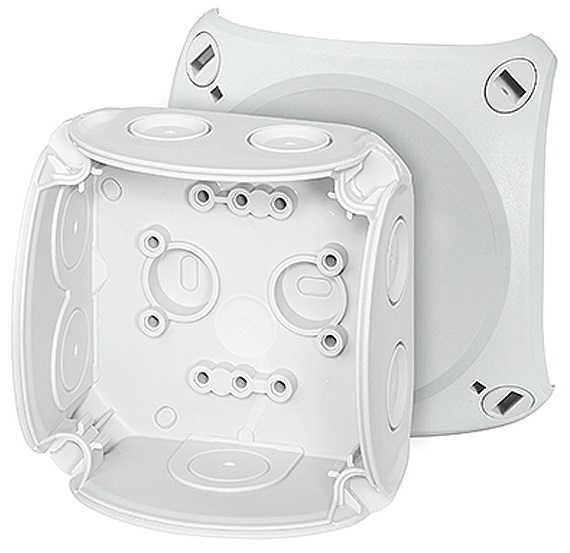

**Abbildung 1: DK 0200 G nach [2]**

Die nachfolgende Abbildung 2 zeigt exemplarisch ein Fotos eines fehlerfreien DK 0200 G.

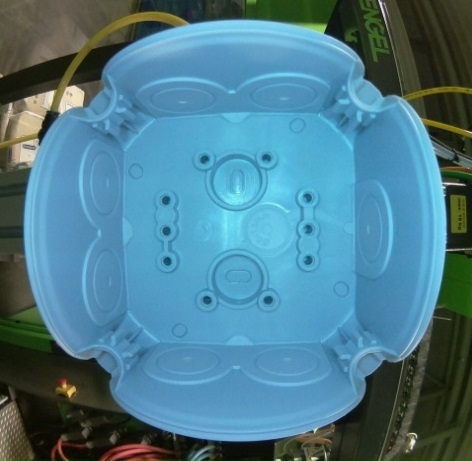

**Abbildung 2: Foto eines fehlerfreien DK 0200 G**

## 3.2 Merkmale
Da moderne Spritzgussmaschinen eine Vielzahl an Daten bereitstellen, wird jeder Datenpunkt durch mehr als 100 Merkmale beschrieben. Es wurde bewusst darauf verzichtet, auf Grundlage domänenspezifischen Wissens bereits vorab Merkmale auszusortieren. Es wird zunächst davon ausgegangen, dass sämtliche Merkmale potenziell relevant sind.

Alle Merkmale im Detail zu beschreiben wäre nicht zielführend. Stattdessen wird auf die relevanten Merkmale an den entsprechenden Stelle der Arbeit eingegangen. Für das Arbeiten mit einer solchen Vielzahl an Merkmalen ist jedoch eine Gruppierung hilfreich. Diese kann auf Grundlage des Fertigungsprozesses erfolgen. Der DK 0200 G wird aus zwei Komponenten – also zwei unterschiedlichen Kunststoffen – gespritzt. Zunächst wird der Grundkörper aus Polypropylen gespritzt. In einem zweiten Fertigungsschritt werden die Membranen zur Einführung von Kabeln aus TPE (Thermoplastischen Elastomeren) ergänzt. Beide Fertigungsschritte laufen prinzipiell ähnlich ab und werden deshalb durch dieselben Merkmale beschrieben. Insgesamt ergeben sich die nachfolgenden Gruppen an Merkmalen:

1. `Internal`: komponentenunabhängige Messwerte der Spritzgussmaschine (z.B. Zykluszeit)

2. `Internal_C1`: Messwerte der Spritzgussmaschine an Komponente *1* (z.B. Einspritzvolumen)

3. `Internal_C2`: Messwerte der Spritzgussmaschine an Komponente *2* (z.B. Einspritzvolumen)

4. `External`: Messwerte externer Sensoren (z.B. Umgebungstemperatur)

5. `Time related`: Abgeleitete Merkmale aus den Zeitstempeln der Teile (z.B. Zeit seit letzter Wartung)

Für eine detaillierte Beschreibung des Spritzgussprozesses und der einzelnen Merkmale siehe [1]. Die Merkmale teilen sich folgendermaßen auf die Gruppen auf:


In [5]:
# Im DataFrame wurde diese Gruppierung mit Hilfe eines MultiIndex umgesetzt
pd.DataFrame(df.drop(["Labels"], axis=1).droplevel(1, axis=1).columns).value_counts()

Group       
Internal        59
Internal_C2     21
Internal_C1     20
Time related     2
External         2
dtype: int64

Die meisten Merkmale sind interne Messwerte der Spritzgussmaschine, wobei jeweils ca. 20 % einer einzelnen Komponente zugeordnet werden können. Um die Daten nachfolgend einheitlich darzustellen, ist es sinnvoll, zunächst eine entsprechende Funktion zu definieren:

In [6]:
def formatForPlotting(df):
    for number in range(10):
        df.columns = df.columns.str.replace(r" " + str(number), "_" + str(number))
    return df

Die ersten Daten der Gruppe `Internal` sehen dann bspw. so aus:

In [7]:
formatForPlotting(df["Internal"]).head(3)

Name                 Ausschuss total [ASZ]  ... Zylinderzone keramisch_3 [Pakt_5]
2021-01-07 17:38:11                   73.0  ...                              15.1
2021-01-07 17:38:47                   73.0  ...                              14.6
2021-01-07 17:39:23                   73.0  ...                              14.2

[3 rows x 59 columns]

Die Merkmale der Gruppe `Internal_C1` sind wie bereits erwähnt ähnlich der Gruppe `Internal_C2` und sehen so aus:

In [8]:
formatForPlotting(df["Internal_C1"]).head(3)

Name                 Dosierleistung [iwdls_1]  ...  Zykluszeit Nachdruck [ZNach_1]
2021-01-07 17:38:11                      7.01  ...                             2.0
2021-01-07 17:38:47                      6.80  ...                             2.0
2021-01-07 17:39:23                      6.82  ...                             2.0

[3 rows x 20 columns]

Die restlichen Merkmale werden nachfolgend bei Bedarf dargestellt. 

## 3.3 Zielwerte
Der Datensatz ist gelabelt und umfasst somit Zielwerte:

In [9]:
# Die Zielwerte bilden eine eigene Gruppe im MultiIndex
formatForPlotting(df["Labels"]["2021-01-13 17"]).head(3)

Name                 0_leak_corner_tl  0_leak_corner_tr  1_hole_bottom
2021-01-13 17:00:28                 2                 3              0
2021-01-13 17:01:04                 1                 3              0
2021-01-13 17:01:40                 1                 3              0

Jedes Label beschreibt einen Fehler, welcher im beobachteten Zeitraum aufgetreten ist. Die nachfolgende Abbildung 3 zeigt ein Teil, welches alle diese Fehler gleichzeitig aufweist. Dies muss nicht zwingend der Fall sein.

![Exemplarisches Schlechtteil - markiert - Kopie.jpg](
fN+FUZBtOR+VdRwxjrYrlmeTd6dBjpQJNoY9uppx+8eeRzTZmDgbeCDQjTlsRnczbvxFRmQhWyu3PWppWXNQsS4Zd2ORitCHG5XutLaYrLG6x3Kchh0I64ps0OoXq7JPLt42++6srHHsATz9auBcnd97HGMUNgAbm6elaLcfM0rFeS2jstKaOFdsUaEDJ5PvXi18C95I33jvPevcb6AnRrltpZVQnpXiNxh7hyo24c/jWde1rHXgZO7Y2JA/c/LVmOD0pkC+vrnpVxPl2j+lcWzPWUbrUfbo657/hViFw6bdvzDrTLc4P6c1bhRWj3fKDmtNCeXsOUMZF2enNXYI8sAevT6VCIfJ3Hjp2q5ZpuZflB+tNbk27nSeBLZmiaRl27W259etbemWx13xdBGvzbXHSq2jxrpum/N8uRn610XwbslvfEMl0wwtupc1UpWVzhqazsjujEZNZSNMbYVCg/zr4Q/4LH/ABG/tb4qaH4bjlDLotmHlXPR3OTn8BX3l4fuYY7ie6k5Rd0jHOOBya/Kz9qWLUvjR8b/ABB4lZWaG8vGChjtZY1+UfhgV+d+IGMlSyyUIby0PoOGcC6lZ1EtjxRhv2rt25FXLU7Rz2GOlW9U0yOwk8uGRZVHUjnmquwqPX8a/metGV9UfbVIOLsya2hErFSwx14rb0mBkQEcDHHNY1vuYrt+96V0VnbmODoWcDkGuOsrGLhpcdsb/npRUe9aK5uV9jHlR8x2F09udrIw9Paus8Maptljx0710a2mgarcvDJBJa3CnB2sGVcgHGD/AJ5rQ0bwNb2N+JrGe3lK9PNXAFfqMswil7y1PuIZxFfEtTa8KQatrUix2dq2G6yOdq16DoHwcjumVtUvHuD1MSHC/n/hXA6v8S9V8A2MMkmmNdo0gjH2Y5xmuw0f4tK1urT2t1bswHEkZ4zXlYjFVJr3TSWac63PUvDWgab4ah2WNnBANuCQMsfqetfRf7Hnj1YNam0eaT93cjMYY96+QtM+KFrct/r0XtjPNdh4A+LP/CL+JrG/t5V3W7hjg/eHpXpcL5pUwmPjUk9Ho/meHmUViKTi3c/Q7w/IbeC+05sbrVvNh90ParVnc+YHVj0rl9A8WR67oOl+JLZ/MjkRVmx3Q962r6QWd4WXlJPmUg8EV/Q9OpGSuj4OpRexk+J7TDsfxFcrdkqSAOvU12mrsLm2OPmbGRXD6oTGzfSuqnK+xj7NmfcyKo2+h61u+B9cRre402Zv3dyDgHoDXNXsvFUTeyW0yyRt88ZyDW3N3CdO6NDWLb7HNJC38OVPvXM6lJe23ywyeZHnADnpXS61q8XiG2W4XC3CjEi56+9cnqd75cZO5eDk5OMVDVxxjZDrWJrWTz7p1Zk+ZY17Gs7VtYjt5WlmbBYZHPNYus+MtzmO1y7d5D0FYcN4bu9EYZpp5DyT0/Kl7T7KIlFWuz1r4PaQ/jCa6Z2MBkXbCA+NxHXPr2ra1C0OlXMkbAqYyQRWF4Qum8M2sHlyGNl+bIPOa9AuoY/iFoxvLVV+3RJ+9jH3nA716EU0jwa8mp3exzdvNnn+8KljucHJ9azZGawyO/TB7VN5/mKwUjj1paDcUakcwZsjNTC7x82fQVk/afK3bSducHNON22Sp9Klq5PL0NZZxI/J74FOMuB/s9KyzeCJA0hCr6scU6O/ScHDKwPcHNMj2fc0vP3gfL8vrmqs2nb7jzraQwTeoH86jF6E6elOtLksSD93r9aCZUyw9xrEMaqs9ntxjcUPH9Kbomi7b5rm7ka4um+XeRjA7YqSW48yEbifXGaS3vArfyqrIzkrbI3VhCf6z7vrmq82j29w3yqyn/YYr/KnWl6skODnPepBMrTh+g6YNF7nLKmVm0SHn55t3Yea3+NLFpsNthljUsvdvmP5mrFwyoMjsahe4O1gD+NIfK+g64QTxFD91utU7LTrzRkZrK4Hl5P7qQZUfSpt+F5PSpGu0MRqi4qSKrXGqX52yTQwxng+Wpz+tXrQLp9psXrn5iTyfrWat3sbdk/nUjXfmKWA7cmosHK+xcuZ13Z3AADj3qpLde2DVaW94+YVVk1Dd93qP5VaYnTa1LZuv3nUBaPPVmIB+X2qh9pyny/NzTRd4l5+XirjYqMXLQuNJkH+VME2DnjHpVJrn5SGb6GkhuPLHytu+taJsPZM0UvNsny5x3qaJGu5tu3nNZsDvI21eSeSPSuj0N4NDtPtlyfudFbqx9KqOuiMqitp1L+v2keieDpFkK+fdIVVe/Svmy+kaK7kX0Y5/OvbNc8QPrU7zSt14AHRR6V4p48g/sLXZDJzFMxZce9c+IukduDo8ujJLeXBzntV6OXzIx/eFYdpdo65+ZvSrkV3jhTjNccZXPV5XE2IXX5Rnr3q1DywX+FecjvWTZTsWx/FWhDPsG5myx4+lVzEpXReglBcg7tvvWpokf2q5AX7oxWJBJlupx2zXR+GIAB5ma0i7mc0+U6DUrsW9moX7zcYz0r0DwFaLongKa4b5ZLo+WnqQeteZ24bVtXghjG8s4UAV6xrcA0+TT9KXn7HCryAf3m5/kR+dZ4irb3TGGHlZyOV/aT+IP8Awqf9nHxFqUc3k3dxata2zejvxn8BX4/a1rNzqd8zXN1NNISTl5MnH4mv0b/4KT/FyXRvBb6Hpswjl0qNJ5XwrrvchdpDAjIUg/ia+AW+J011K32/S9H1LHB863Ksf++CtfkPFuYe2r8kdon61wvlqw+GUnvL8jmbbUJLNt0cjKvp1H+FTWnjczasLaa32qy53qea3l8VeGb+KT7V4bmhfBwbPUPLCnt8ro3H41wtgFufE91IP9Wq4XJ6DP0r89xODpTi3JH0LwVOompHaabrdtc3XlxTK8inbtzhhXXQzYtk+Zg3fNeD6SWufFrNHuBMpIIPSvTtb8UzeG/DTXTKsnkru2sfvH0zXzmKyOUv4R42IydxTcGdV5q+lFeUf8NFf9Qtf/AkUV5n9j4vseb/AGfV7HTnxFpepAfbNOi6ckKDVi18OaFqTYtbqS03fwiTGPwPFcra3MN5aq0cscmeu09TU0cLRsO248/hX1FSMurOydHW7O2j8E30RVrLUoZ1XoJV/qKtLD4j06IrJYrcRg9Y3EgP4HmuOsNRmtSDHLIvOMBq3bL4i6lYOoMqybegeuVxl0Zzyp23NFvEEMXzX2kLHjruiZP1FWbXUNEupAy/ardm6+TOCB6deamsPjQ23bdWMcgxzhuP1rQXxh4T18L9r02ON2H3vKx+orP2k4u5nKLS0Z9bf8E+/jRp8+my+D7nUnug2WtxMuG2kcqPXFfSkMEkVpLp8hzcWPKZ/jjPSvzX8BHw74f8Q2eqaPfyWF5ZyCRClx1wehBPQ81+iHwo8e2/xj8C2uqadNDNqmnx4kVTu81R1U1+0cH8QfWMP7OfxRPMlh27ovQ3PmDy2PPTPrXO+KbPaoZRW9rMSwlbmMHy5Onse4/A1n3jC8t9rCv0OMr6o82VNp2OHvzzWXeTqo29+ua3tasvszsOqnPNc7eL5KtxubtXUncxlBp6mHq+oywn5ZPLZT1Heuc1/ULi9RmuJAqjjC8Z+tburQNcSfKpLE7Qo5OamHgR7KHztTV4Y85VWXqe2KTuc9SXKzyvxbfXWl2wkit5WjY7QwU4Ga7z4ReA7iz03+0LxNssygoH6/Wu08C+E4fGj3TTeXDbWRzHCw4kwM5/DH61neL/ABNtdoYf3McZ25J/pU06fLLmZlKanGyC7v8AbK0bfLtOOuK8X8D/ALTnjTw34C8K+JNW+IHwr8Lt4j06HULeDUdFmiHzxJIyKz6knmbPMUEgDtkDIz1Ou63fatrq2MKzK7HJZhjA9c+leZ/BieeH/hSsdu21rj4eXEbEfwqf7Gz/ACr8+40zDMJY/A4HA1nR9rKSbST2Sa3OvB0EoNSta+uieijJ21TS1SOr1v8AbBvdZuHlk+LnwHjaQ5Jj01hnPt/avFUB+1JeD/msnwP/APBef/lrX0N4G1ZvCjQG3ZoWjG1SDz+P1r0CO2s/iPDuh22+p45VziOQ/wCPet48H5+/+ZtL/wAAicVTMadP7H4Q/wDlZ8dn9qm824Pxk+B/P/UPP/y1oX9qi7z/AMlk+B/1Onn/AOWlfTmp6FJpN01vMmyZPvA1Tl06RZNyqvXgHtSlwfn/AP0NZ/8AgETSOY0nry/hD/5A+Zb79pGbU7hZJ/jJ8EZlT7sZsDs/L+1akX9pi4iZfJ+MXwMh2/8APPTioP1/4mmK+g/7GutHaRrVRKrvvaJ22kH2PTFQXWn3utSqLwfZrWNs+WrBnc+59Kj/AFRz6/8AyNZ/+ARK/tCl/L+EP/lZ4eP2s77/AKLH8Df/AAXN/wDLWlX9re+jPHxi+Bv/AILm/wDlrX0PafKgXYqkYHHYVoW6856e9aLg7P8A/oay/wDAImbzGkvsfhD/AOQPmtf2vtQClf8AhcXwL9f+Qc3/AMtaE/a81BP+axfAv/wXt/8ALWvqBOi9MYqSK2+f71V/qfxB/wBDaf8A4BEweZUetP8ACH/ys+Y7f9s3UoPu/GD4E/8Agub/AOWtSN+2tqh/5rB8CP8AwXP/APLavqSMLAMlgOOpq9pFnNrR3R/LCvBkYcfhR/qfxB/0Np/+ARI/tKh/z7/CH/ys+TW/bY1SQf8AJX/gP/4Ln/8AltTT+2fqjH/ksHwJ/wDBc/8A8tq+yV8I7oflmZt3+zWRqmmTaJcASLuixw69M+9T/qfxBf8A5G0//AIk/wBqYdP+H+EP/lZ8lt+2fqjn/ksHwJ/8Fzf/AC2ph/bI1J/+awfAr/wXN/8ALavq0OrL1De+aGw4wDz3qv8AU/iD/obT/wDAI/5lf2rRX/Lv8If/ACs+Tz+2HqP/AEWD4F/+C5v/AJa0q/tiaigx/wALi+BWP+wc3/y1r6jvbdlOc5/pUDnawHTjOSaP9TuIP+hrL/wCJUczodaf4Q/+VnzA37XuoOf+SxfAz8NPb/5a1Gf2s77/AKLF8Df/AAXN/wDLWvpq9uBFlcEtiqMs3ybsMfwoXB/EH/Q2n/4BE0WY0X9j8Kf/AMrPnH/hrC+/6LH8Dv8AwXt/8taQ/tYXu3H/AAuP4G/+C9v/AJa19GrA02Dt781J9iYIGC5H1qv9TeIf+htP/wAAiT/alBf8u/wh/wDKz5tb9q28cf8AJYvgd+Ont/8ALWnJ+1beoePjF8Df/Bef/lrX0xBYtM4XadvHI71uW+nWnhnbcX7bR95YT95/TiqXBvEH/Q3n/wCARM/7Wof8+/wh/wDKz5h8IftPeINe1mHT9H+J3wV1bUJ8+Vb22kSXE0mAWO1F1XJwAScDoDXoPwn+NOrfE/wRHeeIX006pa6jqGnytYW729tN9mvp7dXWN3kZdyxKSC7ck84xVb9qTxQ3iPxl8M23bUXxRN5can5UH9j6mP8ACvOfgjrW3wzqNmxCn/hI9cMTZ/6i13x+dcXDuIzTBcSVcqx+KdeCpKSukrNyXbyOnEU41sMpxilfle0brWaavFR00R78b43ETbTz6g9PwrivG8i6rFJb3OEkA+VveotB8ZSRyruX5ozscY6112r/AA+bx3oTapaY22Y8xnPGfav0+VRTVjzI03D3jxnRry6spHjuY5ERGwHZSAa6W3mjli3ZB9DXTWrQ+INONrcxxs69D61l6v4TWEZh3KsY+761zxi0dUqibsxljMuR/PPSrhbYQo7nOc1j6fuRlWQZ9q144NwVf71VzFqCLumh5nAK/wAWQPUV1iSrZWnpleMVhaPZCABj1xxmrsJe/vI413Nzt2itFOyuR7NvQ9G+A2hR3mrz6lebls9NQzyNjsO31PT8a6J/ES2Fnq/iXUmEcNqr3LkdPUKP0Aqa80d/BvgjSfDUKFtU1ry7y7VfvKh/1UZ+pyx9tteVftl/ECHw7pFr4G06aOSS3VZdXKt0fbkR59ec/wDfNfL5tmioU5VevQ+kynKXXrRpvbqfGH7V/jy+8QQapdXUnOuXhnID52kH7v0HavnZnDv1/OvWf2ndRt4Z7W2tPnj3GRiX3FCMAivHzKwG4ke4r8fxNWVSTnLqfqHs1TXJHZEk5zC3zfdrO8PBQdQmPQ5GfpVi+nItJCvcdKz9Jdrfw3dTZHzFsCuGtZx1LpuzIvAcLT6/6nd6/Wuk+M96bXwq6nK5wB71l/Cy2FzfNJt+6wpv7QN75Vjbwo27zJNx57Cs6ErysOpqzy/yJP7y/lRUnmQ/7X5mit9Q5UaEE7wbfLkkjbP8Jxg1rWPjTULT/loJgp/iHX8awd/lnO3dzViHlCO+cnPQVtUw8J7o5alFSep2mm/EmFFC3FvJG3co2RWtpnjfS71sLcruzjDcGvOfPTdtU726Z9KSKwSBuijcc561xSy+m9Uc9TL4S1PYba9W4t/kZWUjjBpsEvzfKOnpXl8F7LZvujuJEx2VuKv2fjTUrE/LMsy+ki8fpzXHLLnbQ4amXy+ydxrQafTbhRlSyEAqcEcV1P8AwT2/bP1D9mD4mrJqd9eTaLdHyp4WlLLGAfvAH0z0HWvLH+JkqxFbixDDu0TZ/Q157q0udTmdFkjjdyygjpn/APXXr5HUqYWpdHZl+FjFtVYn9BemeI9H+K3ge38TeH7iG+0fVEEkhiO4QMed4x29RXK6osmkTMvHIyD2P0r8t/8Agnp/wUY1r9knxPHYXrSap4Ru323FkWy0Oerxg8fVTgH2PNfqr4a8beE/j/4B/wCEj8Hapa6lprIXkhjkzLZkcn5TztHGQRkZ9+P1bLc2g0lfQ8HMMpablE57U51mi4+ZiMYA5rFl8MX1/IEhgYr1L46VuXHim18KMyLYzXVyCctIpRV9MZ/OuN8UfEjVtezH5y2sbH/VwLtr255jSp9dTwf7PrVPI3IvhzHZ/vptSsLeRW3bWl+bNXte0G68V2kcX2yzuhGdy7ZPm/KvPbTw01vaG4mvJlk5csSrY+uRXG6j8WdYtfEZj0y3t761h4dnDIzfQr/hXRHGxsnLqefUy+TbS6HufhTRo/CFrdLcrJHMyn5SOGHPSuIHhb7TqUlxcL8pcsie3vWl8NfjXD4otfsOq+mCH/1kHuDxuX9a6DXdBkhuY44TGyzYMUrH5WB6V6EHGSvE8u7pycJHC+M9Hj1bSntY2aC5kG1ZEHzKPTPpXhv7N+mf2nf/AAZjzhl+G1y68Zzzoor6nj+GLrMW+2wSTHqpyOfSvkL4TeJ5vCFn8G7m3/1jfDi5jDY+5n+xju/SvzfjBqOe5W/78/8A0lHqZe+eNvN/+kTPo51bS7pre4zHKvJBNaFp4yi0UBY5GlkXn5e3414nbeM9S8Xa3J++eYyn5pScmu60rSzFbpGctkYZj3r9Eo4pvVHm1sMtmehXHxvmv/MW4s4Zt/3WZcSA4AySPQKPzrN/4T4mTf5HJzx2xWXoXhy88QXvk2Nu9xM3UL/ngV6L4Q/Zrkv1ZtW1CSEBN/k2kXmt75YkAfkRWeIzKnS+JhRyupUXuo5MfEGJU+aFvp2qSLxvaFBut2wetdd4g8A+F/Adrvvms7aMNjzb+8CY/ElR61xGvfFjwDpt4trHrmhic/eSFvOx/wB8g159TiTCw1nNL1aOynw9Xl8EWy9B4lh1G58qzhd5FGSoXnHtWpHry24USaa44/vHmuKHjfS9S1e3bTtQhfJwWjiZG/UDit+4nvGcHzpHX1B4rswOdYbGX+rzUrb2dzix2U1sN/Gi437mwPFtnGzB7GTpwPMxUq+LLNh/x63CngcODisRr2RT+8VJPqKZuhn52+S3p1DV6vNpc4Pq8bnRQ+I9Oku087z1jU5Pylv5V1UPxU0WCFYY/ORV6DyT/hXmXktu2+p6CmqjYbpwcD3o9oTPCxk7I9TT4r6TGGHmTfMP+ebVFdfFDRby3aORnZWGDiI/4V5sqbR/s+9I0Hln5dv/AOujmI+ow3udO3iDSY55PL891B4wpWo18ZacDn7Dc89Pn61zyRMYyv3V6kipIlhj+6vmHsT0FO7H9XijdPi+xkP/ACD7j/vulPiC3uFxHpcxxzncaxxdyudsarH6bVFbWitrtjp0slqoKtgFpEXgc9CeM1y4rGU8PTdWrKyXVm1PC87sjL1PxFBpt2HuoJYY5B8iH73H/wCuoJvHGloQypN+Iq7qvhvUNZuVnliinkx1ZlYj+lZV/wCC75Fz/Z/y56oAc/XFePR4ryyTsq8X80afUdbIlf4gWo+7bzbPU45qrc+P4EePFu7KCCRnqO9YbS2xlZQuGU4IV87TVZtkjYWRc88Hg17UMdTnrF6E1MulHdM7d/jKtvZBLfS4I2XP7wkswBUjj6Zz+Arl9S8evrd+0tzKxkLEEnt9KoRHzC6kYJ55rC8VWpEjFcqxHOBitJV7K6MaeFjczvjZHnxZ8M5N3yt4nlH1/wCJRqVc38FfAUmueF57p5hFDJ4l1wEj7wxq95/9eqXiLxPPceOfhzpM7FzD4kmmRj1AGkakD/MV6d+zD4WuNb+Ek7Q28sqt4k19QVX/AKjN73r8ywklU42rP/pzH/0o97EXpYWKXaP/AKVUOi1Hw7DPpqxxqFeIfIcct9a7T4axG4+GV1aeYkUhZwysfu1z40q8025+z3UMkMnQbl616j8N/hAt1YfatQk8i1f5gMcuewx1J9gPyr9MlyU43Z4vLOfuo8ksvB88txGqW8knlsOUGQcGuy8U6VqHiLSoreHQzCseDvCYJArtPGHxr8MfC7dYwwp9oj6pFF58y+/BCr9CTWPbfHCHxlpnnWK3bBeGjcpCyn3GD/OuCOZR5uVHof2bOUVJnkeueC7jTpfMaGSNupBFQpalcSYHHGD2rpNb+LF5p+svFqFgjWmcjJ3HH1wM1as9a8OeMIGjhmW1mYZEbnbzWkMVTm+XZ9ipYWrTXM1deRzgvMKNvzew7/5/lmvS/gV4Vtrb7R4k1Zd2k6SA7DO37VKc7Il92Yc+igmuO8H+AZtc8QyQ7o4baDLz3ErbYYIx1Zj+fuTgDk13fiLxjoOl+Fxqmp3M2kfD/wAMcx7v+PjVp+nyj+KWQ8ADhF98k+XmOOjTThf1PYyvL5VGptehJ8Uvjjbfs8fCzW/ip4oaGTVrzfHoVkxx9quCDhlH/PNAB06AH0r8+B8TdW+J2s/2xqF5NeSaw32q5nQYaRm5Oe/BOB6AYFc5+3N+1b4v/ai+NH2PUNPXSdGjuFstFslBaOyhU7fkYfKzNkFjzz+u9otjD4a8Px+WzSNaxKpKjqF4HH4V+X55mft5qnF6I/TMpwCoQba1Z5X8fvL0/wAcSWsDM8axqw5PBYZNcKhc9NrZ7muo+Jes/wDCR+Lry7YbWc4AUdAOBXOIoC8eteFUkjplHmdyj4gd49MdsbeOlQX7LaeEIY/u+ZgH6VL4mkZo1j67mAqt4ybyoLOD5lYDOOMY7Vx1tbJC5bM6T4Q2G228zpk5ya4/496of+Eht4WB+7uGO2eK9D+Hdp9j0Qsf7vAzXl3jiX/hKfiTFF13TrEOOFGaeHSTbDqH/CBS/wB1qK9f/sGP/pl+VFV7QDxC/sHgVWBj+Yg7c5OKglzM3y/Kq8YFa1zZtF8oXoMYqB9O2qR79a9Dm0NpU9dCjGQCAetWFYKfXnkVI1iwk6c8c4ojtGG5vvVm9g5dCWNVI5/n1qeOPePlX7tQRRYZePcVdt4/NJ46VJPs7ke1ih2ru+tU75WR/u7t3WteMLJwv0pbqwW5GD94dx3rSM0txRp66sw1tY3Pzwp7nbXX/C/4x+Ivg7rX9oeGtZ1DSZ8jd9nlO2QejJyrD2IrIj0Nrhc/Nt9KadEk3Asi/L0OK66eIcXeJdSinoz6x8K/8FePGFlpSWviDSdF8SCNQEllUwytj1K9TVXxz/wVO1bUdM3aH4N0rT9QbpPNeNMifRNo/U18qT6XIpXCnaP0/wA5qCa3dSuA24nn9K7P7UrtWucjwNNvVH0x+zz+2t4u8deOBovjDUlax1RisUscMcawuTwMqPunOOa+r9N0CHSLIpEvzN94+v8A9avy9sLt7K8V9xDKc7u/tX11+yl+2F9uitfDXiiZVmH7u0vnf/WeiPn8MN9c19RkWbQqP2eIfvdGfNZzlrhFyorTqe3a9A2kyR3lv+7khfIwK9c+H3in/hK/BzRg7WiTz4eehHVfzrzHWIpNSmW3hXJk6kenrXXfCWy/srUYbJdz7S6nPcEf419vh5O/kfGYqmnC7Wpm63qGqajqjSLfXkbKcHbMyqce2cV8+/DZ1/sv4Nxsu7zvhxcxYHuNHFfT1/4istG8O6hZyxq14WPlER9DkZ5r5v8AgmAW+CuRu2/Dq5I4/wCwNXwPGEX/AG7laf8APP8A9JReX+S6v/03M9X8I+FE0WwjCRLG38QArqdI09r26jhXjzHCgD/P+ear28DP833ecg+taOlu1vepIv3lIIJ7Gv0Jw5INx3OGMk6ic9rnR+MfjlpvwE8Nrb6fYSatq0y5jtoWEe49mkf+Eeg5OO3WvBfGX7SPxX8f3k0cviX/AIRewnUg2ujgxuF9DL94n3DY9q67x38MLvUtcuNSt2a4gvG8xs8tCT1U98A8AjsKzLrwRY+HYRc61qFjptv1ZrudI1x9WP6/pX8kcbcaZ3Qx08K4uGumm5+7ZDkmWVKEaqalp3PONH8B2dvefa2WfUL6T5nubmQzSMT1OT39+tdN4X+Ddxrt+0scO3zG3s23GT6msHxv+2f8LPhKrJDLfeKruPgJYW7+Sh7ZlYBSP93d06V4l8UP+Ckup+PUks9PE3hrS2Uq0FrC/mMP9qTGT+G0e1fnSwef5lO8uaMX1d/yPoMRi8FgoWpRTfkfSXj74yeEf2dbJoQ6654gUYW0gYFY2/226Ae3euO+EH/BQC6OuSw+LrOFrG6kLRvaLt+zAngY7getfI7fFXRnYtJdyeY53HzInyc/UU6H4l6G7KBfRAehUjH0zX6VwfRxnD9T21Ftt732Z+b8QYipmXuzjZLY/VvwpqGnfEjRo77QryG+tZBnMbbsH0Pp+NWNV8I3dtp7tJC0Sx9/X6V+cXwF/a8ufg34ojl0XUFnSZgslmc7Z/bHUH3FfpF8PvjzH8WfhR9q1Dw9rWk6tcbPIjudixDuSdp3sCOxCnn2r+lMh4kjmFHZqXVH5vjcqnRk29jPsomkjVmJzirRtg6nK9e/pV2x1bSLyP8A01bixk4DGNfNj/DHzfpWnaXXh3TdQhZprjUrdxhwIXjK+h5xX1WtjxZVFE53ysE9OlEcY3A/wtxXVave+GdTuIYbWOXTo2JMs0oYgY7AZrNu5vD+nDMd5eXzLxthtygP4tj9DVruRGbbuV9C8G33iy7KwDbax/ekPAroI/hFPEGkmmhjhhUvI7MBHGo5JLdAPc15H8bL3xjFY6frvgi4ntbjRHaabSBIGj1OMgDDA4ywxkDjOTyeh+Hv2q/2zNf+O9pPofiLx14p8PWyt5Vzo0NkkVquOzhWWRsf3X3Yz2r5DO+KI4CTpyi7vbTQ+ky3KIYlKTnp1R+iPgb9of4S6r4vk0PS/E1nrOsKxRFBKWjt0wsxwrHPZc/WvUP7Av8AUR86RJGwyqBxtA+lfgT/AMJRefD3XI5dF15dTGdylEdGBHqG/Doa+9v2Hv8AgqL/AGn4X/sHxZcStdWY2wP96UjHTBIyOPwr+dfEvEZ7mdL2mGm3D+RaM93H8Oyp0vaYTX8z9BIvCkluo3tDtUdm618l/wDBUT9tWP8AZq8EL4X8O3cZ8Wa1F80sbZawhIxu9mbPHtWh42/4KQ+F/C/h+8vP+Jl/okRcZhCqzdlzn1Ir8qPjH8WtY/aA+Kuo69qEkt1eapcEomc7VPCoMenQD6V+a8FcJ4yrjPbY1OMI69dTnyHI606/PXjZLuT/AAz8Q+N/EXj6G38MX2uNrmozEolpcSCSRjyS2Dz3yTwO9fqt+yp8EdYuPhI0Pj7xdJe+KCNyLDbLttRj7juOXPcnA69+tfHH7K3xB8N/si+DxdzaDdal4n1T5Li73KpiU8hEznCjjPHzEemBXqtn+3xcX97G2n+HZWuJSFjAu/mZj0GNnU1+lZtn2f8AtlRypOMI/ie1nOHr1fcoQtFdT3iwTUND8TXOiakil4Y/Pt5l6SoDz/MVa1PTvt1o3Lb85Ge4pvgC71zxDpEOpeIbGGxvJAfLgDFniQ4PzZAwT6Y6Ad8gbj2m/wDhwme9f0dwfiMwr5ZCWZRtU6n57jo2qabo8P8AiDov9n/Fr4cyspy2vXAPv/xKdQrvv2cvjHq/hH4WS6fBa2xtofEev4ldjlidZvCeB7kisX4zQgePvhq+Mf8AFSTKD7f2RqVXv2SNNtfEvg7XrW8kaOOz1/XJPlxuP/E2u+Oa+awcHHjWsl/z5j/6UdldqphYuXaP/pVQ+gfhlqK/EvV4768TyrezGcHnn/I4q18Xvilc3V4NH02RoQq4kKHDRj+6Meo5NZHw/mXQvCVvHF8qzTMWPcgdK52e0ktdbmvZMt9qcvuzX3eK5pWuTg6dOLbRND4fhiiJZVlkkO4lvmz+fesiTw9deHNV+1aduAYjeucBhmusjZSildp3dD715z+0d+0npP7OfhlpJvLvvEV2hNhp+7GzPSWbuqDsOC2B268uJVKlT55aWPSw9OrUqcsdbnM/tc/tSeH/AIOzWOiXul3F7rV1As1xslCixDHjOMliQM4yOCPWuZ8E/FrwV4pS3kXxJpto0ihytxOIzH7HJ618ZfET4g6n8TPFd9rOsXTXWoX0hkkdumT0wOgAAAGKwRJ5knQLj5ulfBYjPpyqN7o+4oZJSjTSe5+jeq/tx/DX4Z+El0O3vtQ8X6tNcLttrMmOB3zhd7t94ZPGAe+K+bP2zP2pdc8eeNdbE1yqaboN19k06xQ7baDY2CcDlidpJJ5rxz4HQx3vxf0Frj5re2vFu5cj/lnF+9f8NqGrzeIbGGa6utat/ta3wnl8o/xFvkGMcgjcW49DXh47NKtZ6nr4XA0qK90yPhj8Ur7xb480Gz1Y28kdjqO6AsSQqscswz6nnH/1q+hvG17pttozNKkyOqnaqsFVj796+fvDvhmy0v4qXSaEzXFqp8yD7YB5qoTjkY46dsHpXq3xdih0zwcTc3UzX21WVMYVsnnGPr3rxYq87s74bHkOoyLPPJIqld7FiM+9UhJs+796j7VuAGMDHJNOjkxuGcL6ilUldGGlzL1GVrrWraP7x3ZK+1VvEZS/1uOPO1lAQD0qzpsgm8RSNn/VrVXTR/anizcoyvmcn0Fc03Z2G431PQNOtW0TwO3zbp153e3NeafDVG1X4ks3l+YylpBmvRfHl4dF8GTEjkJt6dzXK/s96V5+pX14wHyrtQ+nXNK9otmPLqd1/aF9/wA8V/KitLzV/wCey0Vz8wch5MFt79FeOQMGHr0ok03L7e/Wuh/bt/Zwk/Yi+PeveBxrFtq154dvprKaWF8pJtYFWX2KsDzyOnavP/h/4wvvFFzJbpbieSKMyN2IUda9hSUo3jsd7jbQ2DpzPF8u5ec01rLy2zztb2rVtrtXm8to2jbo2e3tV/7Arxf3936Uhximc6LDcN3LCpY9Pyeh+btW3Jo2cKoOV5po08jkBsZzTZPK7mb/AGcx+6D+XWrFpabivyHHQ49a0Y7fy/m4Y+laPhzRptUvEt7WGS4nY5EcYLNWdSooxcmaUqadRX7kdj4Qu5LUyR28zRLySF6DvTP7MzFjbnuD6V91/sQfslP8WvhL4tk1K6s7G802zmSNZVIkD7CV/wBk88c14zL+wn4w1bUHt9Et11SRVLlVBXYAOSe2PT1Jr5/DcTYOdWVJzV0fYZ3w7SoUqc8DJz5ldrsfOr6UoT5gMnoKzrvQTI+7aFx6V1+o6TNZtIkkXlyxMUZHGGRgcEH3HTHtVEx+ZHt2898V9H7X3bo+LlFrdHn+pWZtLhh0P061b0y3ad1bPzLzx2q/4jsT55OOh4NR6EmJl+XnPPuK1pzd00cNaz32Pq79iT4j6sug6ta6pcXl5a2qoLRpm3eX6qCeQPavp74NSzX+o3urONsNrEcDPGTXgf7M+nR3Pwcs5I4QGaZi5x948V9T+EfDCeGfhzb27rtluMSSDHWv2LI5VZUI8zufmOc8iqu2lzjLjSH1C+eZt20sT9ec14V+ztbfarz4Mrj7vw3uW/XRa+oJLQL8qKNvoB2r5s/Zai+0at8G1/6ppdH686J/jXzPF6/4Xcrf9+f/AKSjjwcnbTu//Tcz3a30/aq5Xa3pVxNPIH3cDrn0rSisxv3HCkdfX/630qX7Hx0O09OK/SFZ6HkyvfUoWqNAV2nb2BFcF8Tv2UfBPxZv5LrUtMa3vpBzc2chiY/Ucp/47zXpy2bAA/0pyW7MSP6V5+MyfBYt3xFNSfdo7MPmGJoL9zJo+Utf/wCCXuk3EzPpfie8t+u2O5s1lK/8CVh/KsP/AIdb37P/AMjRp+3+H/R33fzr7KigyC2ORxnFCIwbv/hXjVOD8tk9I2+Z6EeJsdHRs+P7L/gllMz7rnxVbr6+TZF/5sP5103h7/gmL4PsJFbVNS1LVGU5KIiQxt/6EfyNfTZXcO60kkQY+/0rWhwjl1N83Lf1ZjU4ixsly8x538PP2a/BXwqlE2ieHNOs7xRgXJi8yb8JGyw/A120duEVuxPGRVqW1JX5V2574oWwKH5vrX0OHwdCgrUkl6I8WviKlV3qNsqpalW+78vSrHk5UY6D2qaGAlfm+XPb1p7RMf8AZ454rp5kcepWki+Taxx/WmwWgf8AE56VcEO6P5uaFi2rxn0o5kaRuVRBt+7u+XjNed/Gj9ljwP8AtAQt/wAJJoNrdXmMLfQ/ubpPT51+9j0bNenGH93xuqNLXeBx+VcuIweHxEeWsk0b0cVXoz56TaZ8Q+Ov+COdnPf/AGrwx4mNum0jyL+Etz2+dM/qBXnvjv8A4JefE7w9e6XeeH7PTdQurXK3EsN9HGJiGypwxXtX6RR2wHT5j06VNBlF28bhxivl8RwZgajvFtH0OH4tx0FaVmj85fi5+xT8YPGnhCzs7Xw2PtEpD3Sm/t1AwOOd/NQ/Af8A4JgfELQ9WXUNbsNPsZoz+5WS9jkCcYydhY/pX6SMjO+cYPtzTfKK1yx4Ewajy8zszq/10xdrRgj5LtP+CbUniFof7d8QLDBG25orGElm/wCBNjH/AHyetez/AA0/Zo8I/CBY5NH0pPtsfH2y4YzT/UE8Ln/ZAr0kxszelN+zYOOvevZy/hfL8LZqKb7s8fGZ9jcQrTlp5aGVJa7224+gx0qKbT2kDbu3pWwLVmfpnnrTWtsAZ/i619DolboeNzM8a+PVp5Hi/wCGbHv4ml/9M+p1jfAzQ5JPAGoXEBaNm8R67vKsRuA1e8H9BXUftGQrF4k+GOBz/wAJPLyT/wBQfU6n/Ze0g3vwpuW2nbJ4j1/8f+JxeV+aYXXjav8A9eI/+lHrzv8AVo37R/8ASqh6fotzj4Z6dIN2YSVcCrehrDrVmsRU9MnPFL4M0AyaZqGntwpXzIie1Jpdk+mzKyNtZT27V93iJOPu9CcHGM07PqfJX7Vv/BSaH4I+N9V8JeFdF+06tp8pglv9Q/1MTY/gj/i+pOPavka68ear8Rr+71rWr2e+1LUJjNNNKx3Oe35dOO2K7n/gqDoEOkftX6g0OzfdWsU8wAxliO/qa8z0aLydDt1K7Sq1+XZ5j606rpyeiP1PK8LSp0YzitWhzHLMP7pJC9jVd2YuBztxj6VYP3Dn7w5HtVVztB3H3r57lPV5jsPgxF9hn8QahIT/AMS/SZVjx1MkzpAB/wB8yOfwqDV/DmoajbW99pzo01iflhADmXCtJIwB4IUAEg9d1aPg+0bT/g/qE2f3mrapFaDHULDGzvj6tNF/3zXP6b4itdM1i8/tCS+jVbeR7TyR+7kkI2jP+zhSOOv4muOctWbRktmdx8DPDUniqe/1zUbjbLqEpLRqm3ocnA7DJ/SrXx41V9EtI7WSLNvcP8pzn5fb9K6L4O3ljB8NtNmkjIkkVi6Z2Y+Ynp/h7V5r8ePHEPiTxAsccMcUdugEYXOF9epzU0ou1zSTUY6HKzwq8ZktJGkjXqv8Q/Cqp1dVgYfxAcjPSsmXVX0yRpI3x7A9akM0Xiaw8w/6PJypwOtC8zllrqLo95stbyZPmZiQCe3+c1p/C+0a51Ddt4/vGufLLoeiPD5m5WbqOp+td58I9L8vThMx+9zx2rnrJXuU7xRV+OWqtFYR2qsQJCCcHrWt8GNNGmeBfOKlftBLk/XP9K434rXban4ujt927ZhQB6mvUbCyXSPDVrZruHyKp9zjFY1l7mhMe7K32xf+ea0UfbbX/JorDlYcx87+IrvWvin4mu7y5kvNV1jUpWmkkctJJNIzZJJOTyTnJ961PgrcXHgb4qaet5BJEs0n2eXzBtyG+Xv35r9CP2Uf+CdR17wpNrWqLD4V8K2LLNPrt4RGx2ZJ25+9n0B9a8g/bh8ceEfitrlj4C+E3hp7qHRdSM0+uTRFbjUZvmHyjqqcnAPoDXr83K7M7oLm1R4b+0Z4buvBWsLLC8ix7scVwekfEy/glUygTQ+vQ17B+2PoXiPRfDuiS6lbRwrGFiuAvzMrAdSf6e9eKjQwNO3Ddt6jHSpoyUlobzi4vU7nRPivaXhWORjHI3BJ/wAa6XT/ABFZ3kX3lbPo1eETqbe42joOgrV0nVZoE3IxX2zWugpLse821vb3C/u2Vd3Tviuq+C/jP/hUuv3mqblj/dYEmzcQB1A788dK8C0vxlc2ir+8yewzW3pvj66muUhO1t3GG5FcWMw6q0+RuxVGs6NRVOx9sfB7/go1pur6jLYwtbR3Fz8jBlMLyepx0bHPFfoN8WPjr8Pf2VP2bvDesaPA2rX3jdUNgq48++dtuSx/hRSQCP4eR1r8MbfVtPTUDJcWxWWMjlRyDzXuOlftLL4m8G6Rpmqao902iRPBZLOcrbRsxcqvplmJP4egr4DMOB6NWvCdN+7e8l3PqMLxG/ZtS37k/wAant9c+I+sajFAIJNRu5riaFf9XFI7sWVfUAnGa4aWwX5l9DjIrobnUIdafzI5kbuSGzzVUaPumJ67h+tfoNGn7OkqfY+XxFTmk5dzite0bz0Zc/TisbT9Na2udp78V6Bq2j4HPPasaXRP324c7TwK6acrHl1oXPpH9irxXC/hy402ct/osqyqo7g9f5V9ZPq0ms2qSLIGhwNoXsK/PP4R+LJfAXiSG8UM0X3JVHdT1r7K+GPxAim0qC5hZrjTbjk45aE/Sv1XhfNIzpey6o/P+Istkpe1Wx6RbQh0wx6D0z/n/P1Hyr4Q+EniiD4d+DLHWPhj8RYdZ8K6JFpP2vR/E1jYHHlQLMokg1OJmjZoIzhv7inANfWFl5d5Ck1u6yQsM7l5/A1oW22Q4ILV1cRcKYTOXSnXnKLp3cXB8r1snr6Hy9Os6OiWt073aasmtGmt02fKP/CtPELDB8D/AB0wOgPxE6f+Vml/4Vt4h4H/AAg/x0/8OIP/AJc19YvpfnpuXr2HrUI06WAt614P/EN8L/0FV/8AwY/8jZ5hVtfX/wACn/8AJHyqfhv4gx/yI/xy/wDDij/5c03/AIVt4gC/8iP8csf9lF/+/NfVUaE984Jpzp29elV/xDbCf9BVf/wY/wDIzeY1bdf/AAKf/wAkfKY+G3iDH/Ij/HL/AMOKP/lzQfhv4hx/yI/xz/8ADij/AOXNfVn2UqvNMEDEfSn/AMQ0wj/5iq//AIMf+RP9qVfP/wACn/8AJHyuvw18QHn/AIQf45f+HFH/AMuaU/DTxAB/yI/xy/8ADij/AOXNfVH2dtu6nNDk45Ht60v+Ia4Rf8xVf/wY/wDIn+1Kr2v/AOBT/wDkj5T/AOFceIG6eB/jl+HxFH/y5oPw28QH/mRvjl/4cQf/AC5r6t+yfJ8p2/1pkkODgn6cUf8AENcL/wBBVf8A8GP/ACHLNKqX/wBtP/5I+Vl+GfiE/wDMjfHLP/ZRB/8ALmk/4Vz4gI/5Ef45f+HEHP8A5Wa+rI4iF46d6Y8GX+5uqv8AiGmF/wCgqv8A+DH/AJEf2pVS/wDtp/8AyR8sf8K28RKv/Ij/AB0XP/VRQP8A3M0f8K38RH/mSPjp3/5qMP8A5c19ULbMRnp7elOWAr7fWj/iGmF/6Cq//gx/5CWbVfP/AMCn/wDJHymPhv4hI/5Ef45/+HFH/wAuaP8AhW3iFB/yI/xz/D4iD/5c19U+SQ3qM+tKYCqdO9P/AIhnhf8AoLr/APgx/wCQ/wC1q39Sn/8AJHyqvw48RHp4H+Of/hxB/wDLmnf8K28RA/8AIj/HTP8A2UUf/LmvqmO2cjpj+dSG3x0z+NL/AIhphf8AoLr/APgx/wCQlm1Z9/8AwKf/AMkfKf8AwrjxF/0I/wAdP/Dij/5c0n/CtPER6+B/jp/4cYf/AC5r6u8jCc//AK6cLZnQN+mKP+IaYX/oLr/+DH/kVHNaz7/+BT/+SPk8/DTxEP8AmRvjn/4cUf8Ay5pU+GviMnjwP8dP/Dij/wCXNfWItcITz7+1OW3+UfLwT1qf+IbYT/oKr/8Agx/5D/tSt5/+BT/+SPk0fDXxI3P/AAg/x0/H4jD/AOXNH/CsfEn/AEIvx0/8OKP/AJc19axWnmvt/i9auQeH5Jj83T0pPw3wn/QVX/8ABj/yB5pVXf8A8Cn/APJHyHpvwr8QWuu6fqH/AArT4u6ldaXM09oNR8Z2+oRwyNFJEXWOfVnTd5cki525Ac8ivd/2T/h1q3hP4QwR69pU2i6pPq2rX72UssMslvHcaldTxBmid48mOVCQrsASRmvWLbSYbVcsvQdaSSZriULGDmvQyTg3CZVipYylUnOco8rc5X0vft3JqYt1ocs1rda3k3pfTVvuytYwLY6ujRr8rHac+9V5tGI1eRFjPlqdxPtXSab4X+zW/wBrumKr1AH3m+g/Kvn7/goR+1xZfs1fB6+WOeP/AISPX4WtdOtlYblBGGlPcBQT+OK9/GYqMYczex1ZbgpzqKKW5+cX7dvj+D4n/tX+JLuzbzLWG5FpG394R/KT+YrmyvlWqqW6AVxfh6STVtfW4maSR5pTI5c8sSSSfzrtLngBd3PfivyTGVvaVZT8z9ao0VTpxiiHG/3Y9wKju4SjN029qnjYqO2akFlJd3UMKJvluHVEHqxOAPxrilrqdEYnaasn9h+AvDdk20NHZS6jJzjLSu23P/bNY684sfFx1q+XT76xQSW5iEcitu3L3A/M/nXpfxYmhXxNc28a+Zb2Ji0+Fc/6xIVCH8wp/OuO8JeBvN8bWHnWsym4VbiOMDDYIyP0yfyrz5WZpKne1j3TwNpEVnAq3Ui3CIpwG+76185+MtPn1nxlqUyr+7adgoHTGeK+l/GFnceDvAc001v5MUcfyS4+92wfevn668Qwq7+XE0jA9xitIysrlVo6WMe08EMXG7kN1zV5vD9vpu1WI2445xzTm1y4nXoseBngVhyCbUNdXe7ERjdjNZ87aM4WKviO1W7uo4VHcZx3r0zwzaro3hfcw2qqd+1ef6Sn9o+JtvVQ+APSu68ean/Y/hCRfusy7Rx1rF6tJE1DgfDEX/CV/ExWwWVZS5J9BXq3iG9+yxOfurAhYH+X864b4CaSWnu76Rf9hT+ea6Hx5qa2+mSE/fkbgZ7VNS7lZEyskcv/AGo395qKxd8v979BRQTyo+vPjR+0n8Rv+Cjvi6HT7K3Xwv4B0/ItNKtgY7W2jXnLY4eQjHXIzjvivdvgb+zPofwr8PadcXEcNra3V20N1fSr++maOPzJQuemNyD1JYfSuw0H4Pab8J9EktJ7KO0u9LuNMhtdJgHz3Mcym4cnvnYqqc9GlHQYra+IV7/ar3V9rbr52s202taLp0DFkD3N2IiMeoSJjn0jX1oxFbm0PqMPh4xifLf7Z/w6n+InwklLWi6fDaxR2rOw+aSZt8yt9CuPwA9a+EdGdZPDOWHzQ5jk9iP8/pX6dfH+6OuaJNdakn7zVlme1sICdsbxqsMWffgjP+wfWvzP+LOn3Hg/4katazQfY4biQukYPAI4P45FRl8rNxZGOjZc5wWr5+0kr6nApdOuDG3vUOqOxkb61Alx5X4V62j3PL5nudDZ3SuMN371es7o2d1G+4/KwNcxFqRgK9MfzqymsfI3rj161FSmpJjlU5lZnrkE8ctk020MJAG/ya4/xS90sh+zoys3TYK1vh14mt5dGt1usmO3l2Sc8hR3/n+VdF438beGVdIdHFxN3MjrjJ44/wA+tcOHpuMm2zmp6NpnF+Gh4qmWZrdZisKmV8NztA5/z7VoaL+0FrGl/LJIsiR9BIOf88VpeH/HVxpF/wDaLWMZXPyOeHHf9M1xuueHp9Tlke1hJW4cuxA+UBjnj8zXoSlc35l0PQ9L/aiguxtvLVT6lDzW3pvxh0HUiGaRoGbswrxO3+GN0xJkMabT37it7TPhc01jMYp2kmiTKp2eq5Ykyjfc9y0DxvpN3xHfW+egG7FesfBr4wP4EvV8uaO5s5CPMi3bvxHvzXw7a2U6zjdmNYzjng1rW2qXensDDeXUeOm1yK6sHjXhqnPB6nDjKMKkHTlqmfrj8O/Gket2Ed/olwjrId0kDcqfXjsa9F0DxNa6qVjcfY7rGCkvAJ+tfjz8PP2p/Fvwc1m3uLHVHbDgNbSfMko75H9a+9P2c/25PC/xusYNP1potD1pgAIp22rI3+w/A59Dz9a/Usn4go4mKjKVpdj89zTI5Urziro+rQrWrKWX5ccH1qzbtHOPmwueDmuT0nUtQ0aFfs8i6hbnkRy9QPZq3tO8V6bqW2O48zT7jO0rKOM/XpX0q5Wr3Pl5RknZmhLokb/dP5VDNoDLgqW4rQgsZkhWSJlmXnlDkVJHdPENsin16VRjK6MWWweJumajNqy/1yK6SGaGQ5bhugqVtPt51/hz6UzNy6HKLbYB3Hgnjini22j5V3bjg10kvh6OT7ufXpUaeHGZj5e0r6mglSRz0lvs+8vT3pfsyy8rzW0/huYtu2555xSPoMyD7vy9sUInmMVbcpuA/PFBtdp3fe5xitSXQ5geI2P4Up0iXzPmjYd6rmJZlfZPlJWj7Nz83atV9HlkfGw+tC6LMP8Alm2O/HSjmJMwWYK8ClNqdvSthNIuHXiE7alXw3cS7Rs27u+aOYJNGHHCGHzcU5bTKD+9zXRQ+D5d21tq+5qxD4SG7DNwPSlzMcZJHK/Ytzg5/Cp4rIsOn0rq08MQwdfm+tTG2t7OL+DPvSbY4ySOXt9ClkYfLtFaEXhMN8zH8K1GvUHyqFJ7YqNDdXrYijbHTI5zU6mik3sV49Lt7L+7u69KZPdIp/dru3Y5rR/4Rpjl7qdLdeN241q6RYaVbJ5mJLpuAoVcKfqx4A+gasZ1VHVm1PDuT1MDTfDV5rU6rHGxGeoGa6KDw/Z+GYWaXZdXa/8ALJT8qH/abt9OtHiTxvD4b0S5vLy8s9F0m1QtPI8oijiQdWeVv15A9q/Pb9tT/gtNovhO2vfDvwvVdVvtrRPrjri2tye8KHlyP7xAXpgHrXk4vGRhHmm7Hv5blU6srQjc+hf22v29PDH7Kvh9m1CaPVPE1xGTaaTEwDKSOGf+4o45PJr8cfjv8efEH7RPxFvvEXiC8a6vLtsBQf3cC9kQdlHHH4965PxX4+1j4h+JbvVta1C71LUL6TzZrid9zOx/z2qGxtiXUL+Rr4HNs6db93D4T9Dy3KqeGV1qztPAFqXnDZ+6veulmUbm/vZ7VkeC7dbayaQ8tnFajlmIZR8rHJNfOuV3c9KXcdGMc8/411vwnt1ufHdhNIoaPTg18+fSFTIPzZVH41zEZV4f5V23wotFtfD2uai+5SyxafE2PvF23tj6BAPxrOo/dKpu5m+M7R10NtUEsn277eqxKhwxJBJP5/qK6r4H+J9V8XeOrjVrzypJDaQ2QEcI3ARKqKQcccKMkY71hWnjVfAXje1ur/T11HS5sOkZHJkTcq7fpJgkdwDXrHwc0RvCvgu3a4hWO8k3yvnkqWYnbkemcYrz0joje5yX7S/iC+FktldSy4kO7YWyCK8XsLEMN5/XsK7j46+I28R+K3AfzFjGwc9Mf/rrkbRNgzjoMVty6WM61TUZPGsUDNuY7eayrNVS0urpiVZhgVr6xKsFid2Pm4FUtRtxHpUcePvcmsaklFWMdd0HwrsfO1N5JMtg5+pq18aNZLRQ2q4+9kr69K2PA9mthpjSj+L5q4vX5m8WeOFQLiNZB+QogmtSW7s9H+HunHw/4LgUjbLMMn6mue8fP9su0t1bP8P411yXKxWS/wDTFOnbAFcp4btW8Q+Mdzfdjbewrnu9WRLVjP8AhX8nq35UV6Z9lT3/AEorn5ma8qP0d1bVF8L6xHrl9cR6t4ourrVIrqNzujgCRrBbyfTe0jD2jWuR8batJ8O7ryWH9peKfD95bFVILRw20UDyyL14VXZQf9xjXdy2Vv8AbYdF0Mre33iTTrOzuLqY8W1zJcLOUB9cIiE+m/3ryH4va1FpsO7Td7XYF1bazesuflndYQSen3c/9/KTlfQ+qWhzPjS6S1WbT4XW/wBYkitrlJuPLgTy/PkHtjIB/Gvgn9tPw9HY+IFvLdpLpn2s838IZxuYE/l+INfZOv6iJYNQs9PkRbfR5rj7VfFvnuYXZIVx+H6NXzh+1F4cj8QeHtQ8hvs+m2MjyWoYEvcgkIDn8M/jTp+5URnWjzQZ8m39wo+6dzVVjbzX+8V7mtCPw3czysuzbGrYMjdBUN7a2djIFW58984IQcCvd5tLnjS7EYsY512+c3rz2qQaM3ylbiMsxwBnFNe6hjOF3t36USQ/aIVk9+OaPMXL2NfRRJpNlM00ipHOvy/NnP8An+tRpqkyQ7oVO3P3m6Vs+EvgF4o8a6GNUs7CT+zhuxMzYRtoJOPXp+taVl8OpNMtliumUFeNp9eaiMU2yXprYtfs+69p8njlbfXmaO1u18sP2jbt+frXt2p+HNB8PaXN9nuIdQjmJ8nyVz2wFH09q8h8E+C9P1LxPYw3s/2e0mkVZnVeVUn5sfhXvH7Ta6P8M/h/a2th5MEdmEa3kTqx46HuDirq2UUkVTs7s8E1bxfp1rcERzK0ZY7Sfr3rm5fi5Na3DG3jXCHbnPauX1jfrmrXFxGvlrMxbA9+ar2ujykbdp69fahbajlsb1347uNRu2meOLdIc4HAqKXxDd352ho4V/2RyK6r4R/BtvHuoiJRNJ5K+ZKEAwij1Y9P1qPx34Ri8DhpGjzbzMyD5tzwsOzcDnms5KOxnKipK5l6VbW8Ei3EvmTSHlTJ/St601RPNUqfm/lXDat4qF/Hbr5ewwKVJXvSWuvzJynXtSVKalzR0OKrhnLR7H1B8GP2+vG3wTEVuLtda0mMhTa3hLbV9Fb7y/qPavsL4K/8FKvh98WYYbTWZP8AhH9QkIHl3v8AqifaTp+eD7V+VtnPfai3yxtJsBZgo6CtKHRrryLaVo2jW45U9Bn0J6e9fYZbxRicMlCo+ZHk1+HcLWjroz9xvDj2mqWyXWi6p+7m5UxyeZGR/Kugh1/VLIKtzbW99GvG+M7XNfiP8PP2ivGfwL8TRW2j69qWmm3kUSRJPmJgcfwtleQT2r7E+Hf/AAVs1jTLxrLVPD39vNHtWMWTFJ5Fxy5OWU/QKPrX2mD4qwlXSb5X5nyuN4RxENafvL8T7+j8R6Xdv+/W4sm7h4zgfjWlaafBfL/ot5DMewDf/XrwLwR/wUD+G/ib4f6Nr+paoui2usGVIhfQsNjx43KzKCB94dSK9P8AB/jHwT8ULZLrQ9c0nVI2G7zLG7WTH/fJz69a+ho4qjWV6ck/mfM4rLcRRf7yDR3A0i/i6KW4xwetEctxa5DRMfw6Vl22kyLt+y6xdQKOQPMDD9c1pRnxBCFMN1b3S9xNDyfxBrflvsefyakkWpMpwI+fepBrKJ8rRinf2nrAXbJpmnzepSQqac2s7V/faDKuO6TLyfxo5WT7MUaxEv8AD+vSnf2nDI46fKaij12zK5l0TUo/XGG/lUker6Uzk/2bqiDqT5WaOUnlJWu4dy/d9zSSajAON3fHFNGqaOcf6DqjKT2h/wDr0+PVtK8vjTdUkxxxFt/xpcrM5RQiajGB/eUcU06ku77nFWItVtzjytB1GY9t0iLxUzaldSDbB4fSP0Ms4/pS1D2elyg99I2VVD7Gnww3d0w2RuzAcZHWrom1yVVVbLSrdc/e+dz+WB/OnrpWrXassurrbr3EEIU/1pOVio09bFVNBvLwbpMRqByS2MVVks9Psg32m+i3L/Cp3NWg3g+3fCXFzeXbHu0h/pxWL4j8eeC/hsG/tTVtD0tkGDHNcoZz/wBs1zIf++TWFTFUqa5pySR24bAVa0uWnFtlq2vrcj/RNPurg9mcbF/M1aS01S6Ta00FjG3RYQGcfQ+v4HvXH6j+1X4Ng0KS606bUtZuAP3Nrb2j2wlIYD/WSAFeCTnaeleRaL+2J8QE+N3hq81Cy8L6P4JttSjOpW6bp7ue23fPuZzhmAyRtCjgGvmcx4uy7DRb5rvyPqcLwfmElzOFkfQHia90X4daO2reIL6y0+0UZF3qNx5Suevyluv0AzXzP8Yf+Crnhnw/ctY+BdNm8TXu4KLydDb2KEnHCnEkn0+Ue9ebftgeNJP2rvjBfeItWuprzzGMVlZwtmGwgH3UQDgY/nk9xjg4vAXh3wZZb7owWrKNyxjEkxYY5xwFP+fWvi8Vx5WrQtQp2b7n2mW8G4eilPEy17Hkn/BRf4m/Ej4m6tZya94nbUdJugDHp8GYba0kULuHlD5SctwxycDrXyc3hKSS6jWWbazt8xHJr6W/aR1xPHeo2kNvCtutlEUkKOX81yxO7OBjtx04rxGfRJINZWM8so3Zz1rxP7QxNePNiJantyoUKT5aCsiHTfANiiht8rMRk59auX3h+106FfL+81aUOmunzfgRiq9xC8lxtKn5OB75rDmuy9ErF/RYzb6Ym37zc/SrmxljUZ/Wo41WGNYzxtUZFPU7No+8WPStJPQx0LUasQv3WC8n29P1r0u4tG0T4faFZiP95dGTUnVTzuPyIPoQoP8AwKuD0bQptReGGFd0lzMsKe5Y4H6kV3fxH8T2vhjxPJJKrNZ2bR2UQTGVSNQAR78Z/TvXPUeg1o7I818C2cmv/FrSIrmS6Nqt0geF3LKhDZJ/PtX1nqmt6T4K8OPceS1xIiN5aM+0DjHT+leZfCTw74bf4j6hPp0kk1pFFFBDct0unK5kI44BJB5wRjHY17RqnwFuPjRpq2Ol32i6LFbyoLi81OYxpHkN0VA7kfL1Cn6VyymoO72Ommnax8da/M1/r00g+USMSOenNRQ2rsCfl+XoM19HfGz/AIJ2a58L/h3deLtN8VeD/HGj6WU/tP8AsW5l+0aWHYKjyxTRo4jLELvUMM4BxkV4SlgqSMo49sYP+etV7Tn95dTjlGz5Wc7qFo1/eQx9e5zTdRsptQvVjQfLHxXTW+jMl4JVXcccEjNamm+E5Lss3l+XuPJIxmsakdbkxOXWCX7H5RbyhjacHmoPD/g5be9ZkWR5M53HvmvQ4/A0ER3TbW781aulgs49qKobGMqKJVLKxSitziNb83S9Ek3NtklOznsKvfCvR1t7Ca7k+9JkD6VneM521XVY7VADghTXbWWljTdGgtlUZ2gZWuetJLQnRvQj87/ppRVn+xV/2qKxuUfpPqDxvf6hoOgzLHptrdNqiX75DuLW0csqt/wNyPdlrw/4vXlvrDxrHmw8PXX2aC+nPWaVd0rH8wf++RXr3iSOTVPDsyxstjp2jx3N5aLIpWS6imnji6nqPlAHHRDXjnxvnjmF1NPE1nod0J5dOt0XmSZIwq5/Fh+ZqXJc2h9VzJo8VOu/b9Ntbi9XydPs1is57dDtkuQWeXJ9e3X0Fea+OVn1KxaO7wJYVWOK3HzKISGbJ/P+VdTq+syJqUlzdqsk1xvhW1OQIWSMIrE+o4P1Brl/ESyWt1Mqt5lzlorl+ojXAA/I8VpN63MY22R8y/FvR7nwbr0lh5m6Fgrgjp8wBrH8L/Dy48V3kscH7tY03tI4wtevftL+CZJfDUOpRrza/KzEffycD8sV4bFrt5HbNCLqaMN/dYgV6OHqc9M8+vDlkV7+1+w3zRfe8tihYHg1q/DrwdN8QvGem6Lb/wCs1C4WIEc7ATyfw6/lWJMsgI53An73rX03+zl4f0j4HN4c1PVFzqWrXUSqzdYwxHA9gMEn3pYnEOlDTc9LJct+tYhRlpFWv957L4k8W6d+zx4fHgmPT7zULe1tR5bxICylhk7s9zya+WfGvxBu7nVbjbo9zbwrIdm/lgvbNehf8FENb17wZ+0ldi3unh0/UraC6tcAbXUxgE5x6g14fa/GTXLObdJLDcKf4WTdiscHVqSpqbS1PYzvB4Gni50U3Gz7FiX4gXaStst9mDnkE4967Cz8DePf2kPDdqwQ/wBj6KxiSWT5VBbGfcgZB/GsnSf2iWitts+k6Y8ineGEI5+ua7L4a/tu6h4Utrqxm0+BtPuDkRxnbsOMccd+Pyr0Kcqkt0eHiMLhoQ5qVS7fkcNB8M5PCAmt7yRXmiYpJjkKw4IFTRWdsiDK/Ljriszx38bZvFWv3NylqkEczE7WYsSe5zxXPv42vJMABVycDFXzdzzeXmdlqfZX7Jni7w1oPw+1Szkjjg1ZmaUyPgecuOg9Mc18w/GzxrH4v8ZahDazf6O05w2fvc9f51ofDL4WeJvHkiytejSrNx808rbDj6f/AF69s8A/s5/DDwX5cmvX8+tXmc7YwSpP/Afr61xVsTCm+bdn1WW8J4zFpS0hHu2fLtv4W3xjylZiepwTWja+DLkurfZZpFXp+7PP6V+hvw88HaTq9vGvhT4U32pR8Bbma2WKM492Br1HRfg94skVfO8F+FdJhYZInulYgfRVrjebPpE+uoeFsqi5p1l9zZ8T/CL9nfULz4V3GuPbratMSIkKctGO/PPOa8h+MOpr4WihtbeZRb3Dvuts7pIHGAxH+yePxBHav038X+FZrDSmguI9CCqMbILjao+h2ivlH4w/Br4e3epyy6xHFZ3B4EsN2Dt/AEjvRTzDmldxPJzTw9qYeNoVU/wPh+S8mmu2mZ3d2OdxPJrq7L4gXmjaPIlpG8DSDbIy/e6dj17npXpvir9lXQtWUzeHvE0Nxty3lSFWYDqOhz+lef8Aij4Ra34Z82Py/tCoTkod2a9WniIy02PisRk+Jw/xR+53O0074w/8JF+zdp/hmS1g8zS7+S5FwqAMwYchj39s9MmuIn8ex6bpiSafNdWl6vzCSMlXX6MOareD4rjSdOmguopI90mQpHrVW6WTTy0TwttbIwV6jnoa66eInGV6cmvQ86rh1JWqL7z0D4ff8FAfi58OpIxp3jrXHjjGFjuZ/tK49MSbhX0F8Pf+Cy3xU8OeQuqxaHqkbKNzXNn5Uh98oVH5CvlH4RfD2TWbz7Y9s00MeWVD6CvXPg7+y94y/al8ZtZ6Xo01vaqdpkljKxog74+nOT6171HPMfTtabPna2X4Ko2pwR9XfB3/AILj6r4p1q5s9S8HWTG2G5ZLbUHQMP8AdZT/ADr0iD/guF4R0vUFtdU8M6/C+fmELxyj9cV85237Ofwt/ZjvF0rVNat9W8WOh863t33snscEgV4R+0BrXhq48Xw/YbHyfLGdyEMfxPtXof62Y6HxpHDHhvAVn7kbH6V3P/BbL4S6TefZ76PxBbytGjZFnFIBkZ5Kv1rQsf8AgtP8D7hAJdW1aE46Ppb/ANCa/G34j6ba6Zrq/YZ2mt2jVnVmyYpSORn2Nc6bplZvm57V0Q40r/yomXBuDfc/b7/h9B8C7bn+27zp0Glyg/yqrd/8Ftvgja5xfa1N6eXpbjd+ZFfiSt2zZ3FuD0z1oN3l6p8aVv5TNcF4Pq2fs1qv/Beb4S2ETC10/wAVXTL6WUS5H4uK47Xv+Dg3wnabhpvgnXrpuxmvI4P/AEEN/WvyW+2MVwuRk01rgo2F6+o61zz4wxTVoxR1U+D8DHVps/SvWv8Ag4F8R6xfrDovgHSLdpmCoLu7luWYk4A+XZk+1aGv/wDBRP47eIreZpLrS/B8eeY4tOQS49hJvYfXivzY8ESKni7TWyy7biM5A5+8Pxr7T8UXkmqwLOBLKZQG3lTzmvFx3FuOS5U7XO2nw/gabvGCudTe/HHxv42spJte8Z+Iby2UfvHu7xjGx9EhXCfpWDZfHCw8HzPJ9n+TjNxcfvZDz1I6fhjisnx1Jh7e1jfFrHEixnoGJAyfxrg/HujXD6fPBEuZOAc8cfzr5jEZhiMQ/wB5Ns9fB01QlekkfQXh74wL8T7Rlh1IyW8PzOfNMMcY568gDjNbmmahotnZKsdxFfbe8cx2D/gXBNeE/BPRdP8AFfhlvDT3lxa3dvHLdTiJQDctkAZJ7AEY+h9TXfeGvA1vY+GpPLuJJDdqCgeVY9p2gdSMdQce1eY8PyvRs96nj5TXvRTPQF+I2l6tpptEe1a3zzHDLg8+uPoetcD428P+FfGUNxa2eraxoOog7UaSUS2jv1xtwGXjvk/SvPdK+EmlfD3Xl1HVp2hWM7hBNOspmYHIwqgHH1p2oTnwv8TLrS5JfL03WMX1tLKpKRxyLvX5uy5wvtisPq9T2l4yYVMwg4ezcEchd6ZPopktZ5Fmmt3MburBlcgnkHvXH2VqLzVryZl+VX2D3xmruueM8ySsuSWJPJ61n+G73bpm8nc0shdse9e6otRPD5Unoa32ULkj5qy7m2+ZZMAb24AHpV43JVSxZV/uj17U27tWjvBH94woAcdPWimmmOo9NSBv3Z6ZycYHap1Zd42ksRxTVCq33fl9+9TQW/mzrjK7fQV0S2ucnMeg/AbQZL3xxHdSBjb6PbyXzj1YLhB/30QfwrK8cy6beXz2t3JIt9sMsYBwo39WJ9Rgfma9N+B3h+TS/hJq2qSKVbWLgW8bEf8ALKPg4/4GX/75rnfCngjRviN4st9UaC+VrKSTzHmjzbzchUUKVH3cNzz1HpXNWk0kdVGzlfseq/Bz4WW+meBtPtZLiDGyOZ+AWDfeJ/Alj+FdF4E8Dap4n+PEUei+ZfLI8Nvb2zsfLuyzDIYDnBJx/kVk+J7mDwd4at0ikkWa4HyANwgA6+uMYFdt8CNQ1L4Z6NZ+P1WRNMh1BLQ3UWJJIWwCxCEjkKep4ywGeePOxU3y8i6ndRlC7bZ9Gf8ABWj4AR/sX+BtGh8MaxE//Ca6O2i6lp0iZkNurLN5m8fe/ecbiM8DnHA/NW08FLE25mYr2ULivob/AIKQ/tnW/wC0l+0JfahpV3d3vh/T40s9LM427YVUAEj1POa+W9V8aXV1frbxt5a5+YIe1dkkoU4049Dz6kfaVOc6iWOy0ELuMaHryfmpYddhkt5HjOQMkE964OeSTU9bVWYtzwCa6PxFdL4e8MEBcSSDGR2rmlLmdkTKNtWc3J4g1Dxb4rW1SZlt1f5lXpj3rrNVP2G32sy7oU/WsX4T+H2ijn1CT/locAn8as+NrvePJ+6ZjkkdvaodROVkVZGd4G0VtZ8RTXTLlVJJruEg8694Hypxz2qj4S0hdH0X73zSDPTmtzTrQQ2hdvvN3rmldzuEYRsS/Z4/7y0UzzP9laKd2HIu5+hHiyRvLs7rUjG7aRFZ2UVky4a5hZpJST7EE/8AfQrwf48eY00hmjLXV/H9s0mCI5WESXByOvorjHuPavob40/8lPt/+vXTv/SSOvn34hf8jH4Z/wCvaH/0Y1fMwzqb15fx/wCAV/bk7fD+P/APm7xdavc6ixWVZLrVN7TyMOLZjJ2Pb/69c40KzQSbtywowS5mDZM7bsium8Rf8eeqf9fC/wDoYrmLr/kCr9U/m1brOJv7P4mP9uTWvL+P/ANX4gWmn33wZmnvWjQ20fliJurnnB/GvinWrDyrqRtu0MSQAO1fTHxp/wCRah/3l/kK8F1j/j4k+pr1cvzByu+UxqZ3Obs4/ic9p1x5c0asqtHuBIIr2n9qHVIWt/CrWkzIILUSoVHygnGDXk8P+vH416J8Yv8AkR/C/wD17CujEYy9andHsZfnlSlhaqiu3U9U8QWP/DZ3wT0xrNlm8beF4fLWLPN7EOoHvnkV8v3fhTUNHvbqG9t5La4tyQ8UiEMp9CK+g/8Agn9/yWO2/wCug/mtJ+2t/wAln1n/AK+D/Ja4aeazo4v6rGPutX9D0M0zP6zg4Y2cff2bvufNk1syH7uGxycdaWyYWqyPJGZGx8vH3TXQy/0qC6/49Gr3I5hJ9D5X+1p32OfvB+9TywSZANxx3r3X4Cfs7td6ede1aMQwwr5paUHy7df9r1b2968k0v8A5CMH/XRf5ivsLUv+Ta7r/r/i/lXn5lm06MVCMd/M+w4VxUJVpVKkOblV1r1MHwj8GL/416uqx3Eml+H42+aRjtlmUdTjoB7ZFe3aF8VPhB+zLpqQ7rHWtWteBISJmQ/UggGuY0X/AJN71T6N/wCgivjfxJ/yMSfUV5uFx8q7aatY/QMRxU8HGNSNJOUure3orH3Pr/8AwUi8RePoGs/CdpdxLgqn2W23HH1PFed+JdO+N3xPlaa717W7GzY/6rzsEj6DGK7/APZB/wCRRsfpXp3iz/j2b615suIHTlaFNfefRQzyviqCqVb+idj5Ck+Ds1jqscfiTVPEV1JI2W/fE7vXvXReKf2ZNBuNDa40/Q9evgFzvMuSfwzXUeN/+Rhj/wB4V6v4M/5FmH8aupxBVVtPx/4B40cwpVG4zp39Xf8AQ+DPFnw4bQLiXbY6tY7QcBgcj8q5+/8AEOuaZEVtbi+YZ5DgsB+dfY3xo+9L/wAC/lXhmv8ASeu+hxBUdrx/H/gHwWc4tUW+SP4nkGjeIdUvdRY3qtIqnIJj703U7e/vPEW6ZZI9zYA2/wBO3Wu1uP8Aj9j+h/pVTxb/AMjen/XRf/QRXsUM6k5r3fxPh8wziSj8P4n0z+y58C/+EttLXQtMVftV0qtqN6eI7OPqyg4645Jr6p1lv7J8A3HhP4fzp4c8L2SeXrHiJyI5r5v4gj/wp1xjk15N+xB/yRLxt/16N/Kuk/aI/wCTI4f98fyr6ZZxyR5uRP5/8A+AlnlR1bNfj/wD5q8YeJ/hPoXjYaLpEF1rOqXDlZL91+Qv3O4nJz615T8V7bSfD2ubraKO6uLgbSic7B3zz19PxqbwT/yM8f8Aur/WqXjf/kdY/wDgX/oD142Mz6pJ25fx/wCAfQYPNuT7H4/8A88+JzafLdWbWcbW9xFAEukOQskoJ+ZfwxXISSN5pAH4Yr0P4g/8ftr9P8K5u6/4+PxFRSzKTV+U9Onmrmubl/Ew0keX5I1JbOOlXLTSLp1I8teD3rQsv+Pn/gVbCfdb61VTNJLTl/EUsyknbl/E50+Hbhl6r68dqpXEbWspRu3612MH3m+lYt3/AMfjUqeaSfT8Qjmcn0/Es/B6zbUvidosQB+e7TqM45r718e6B4t+F/gc69deCfEH9jMoRdRudOdLLLfd2ykbefY18XfAf/ksPhv/AK/Y/wD0Kv6A/wDgq7/yiR03/sHab/KvPzDNJe0S5fxIqZpKOnL+J+Gc3xj1nxJ4gmkuMSR+YypbgACPnt+XpX0R+z7+y945/aL+G114l0fw/cX2k6TIYb68Z1UREANg5PXBHQd6+Z/B3/Iaj/32/mK+/P2Bv+TVPG3/AGGv/aSVlLNWnyqP4kxztxVuT8f+AfL8Kap8Ff2jdI0/UFs1jmlSCUwyGQqkuVAPHUFhX2B8G/2GvGv7RNlrmjeEJ9D0+40SNb27l1afyVijlkfZ5YwxbAAHTj8q+L/jn/ydzpf/AF/2v/ocdfql8NP+Rx8V/wDYsj/0IVx4vOJxkoqP4mmFzttv3Px/4B+b37X/AMPNU/Y78dyaT4gXRNY1LaGE9vqaXiFf+An5fYHBHoK7f44fEDS9U/Yz+F3ib+z7GTVNW8P32j3rrCvyiO7kZD067LpQD1+QelfJ/wC15/yVW9/6+G/nXqHjn/kyz4ff7tz/AOhx16EcZGEVLl1fmVPOpL3lH8f+AeC6xq0c6tHCgXdwuR+Fa2kS+TbQoE7Acd6wb7/j7H+9WxY9Y/8AeraebSSso/iL+2pR+z+P/ANuJFu5o45A3DbsAdMVOknnq7KG3Oc/hVXTv+P1v9xqfD90fQVnHOJX+H8TCtnkt+X8f+ATpl0YkbccAHvWvoGltdwsqqz3EmFiUfxMTgADvmsi0+5+Ndz8G/8AkqnhT/sL2n/o5K2nnU0vh/H/AIBzSzuXN8P4/wDAPpfxR4Gh8J+GfDvhNt23TbBDdlR992HzZ+p3H8awtavLX4d6OsNuEZoTiOEjn15/OvQfi9/yUzWvpH/I14T4+/5G26+q1jiM6nouX8Tpp55Oz938f+Ac3458WXepFpJpG8yU5GP4BzwPzrmU8f60bBbJb67W1XOIRKdgB9vT2q/42/13/Af8a5iD74rh/tiTXNy/iR/bU2r8v4/8AuwWzuW3YVRz6Cq1pAtuJ7hvovf1qaX/AI9W+lV7r/kCfiKxlnM3ry/iKOeS/k/H/gGl4E0X7TctK3POckUzx/dNrWtx2EJ+7gELWn8PP+PB/wDPrWVpf/I/fjWlHN5X+H8SY55J/Z/H/gHawaevh/RYbZR0TLmuZsrJvEfiPp+7U59q6bxB/qZP9w1j+AP+Pmb8P61zyzmS+z+JX9uP+T8f+AdP9lWSRI1I2qBwBV+ZMQrGufQgCs+w/wCPn8a0G/11YrOp/wAv4/8AAK/tyX8v4/8AAI/7Loqain/bU/5fxD+3Jfy/j/wD/9k=)

**Abbildung 3: Beobachtete Fehler am DK 0200 G**

Die Fehler `0_leak_corner_tl` und `0_leak_corner_tr` sind links bzw. rechts oben zu sehen. An diesen Stellen wird zu viel Material der Komponente 2 (TPE) in das Innere des Gehäuses gesprizt. Der Fehler `1_hole_bottom` ist unten zu beobachten: Hier fehlt das entsprechende Material. Die Häufigkeit dieser Fehler ist sehr unterschiedlich:

In [10]:
print("Anzahl Datenpunkte:", len(df))
print("Anzahl Fehler:")
# Wenn der Wert einer Zielvariable nicht 0 ist lag ein Fehler vor
print(df["Labels"].astype(bool).sum(axis=0))
# Quelle: https://stackoverflow.com/questions/26053849/counting-non-zero-values-in-each-column-of-a-dataframe-in-python

Anzahl Datenpunkte: 4548
Anzahl Fehler:
Name
0_leak_corner_tl    2103
0_leak_corner_tr    2138
1_hole_bottom          5
dtype: int64


\*) Anmerkung: Diese Zahlen wirken auf den ersten Blick sehr hoch. Allerdings wurde, um einen vollständigen Datensatz zu erhalten, jegliche Abweichung vom Optimum als Fehler eingestuft. Dem Endkunden würden diese in der Regel nicht auffallen. Außerdem wurde bewusst ein extrem fehlerlastiger Zeitraum gewählt. In anderen Zeiträumen treten wochenlang quasi gar keine Fehler auf. Bei diesen hohen Zahlen handelt es sich deshalb wahrscheinlich um einen – zumindest im Sinne dieser Arbeit – "glücklichen" Zufall.

Die Fehler `0_leak_corner_tl` und `0_leak_corner_tr` sind mit Abstand am häufigsten aufgetreten und stehen deshalb im Fokus dieser Arbeit. Im Datensatz werden die Fehler als eine Ganzzahl zwischen 0 bis 3 codiert. Die Zahlen haben nachfolgende Bedeutungen:
- `0`: kein Fehler
- `1`: schwacher Fehler
- `2`: mittlerer Fehler
- `3`: starker Fehler

Für eine exakte Beschreibung, wie diese Einteilung erfolgt ist, siehe [1]. 

In der Regel lag entweder kein Fehler vor oder dieser war sehr stark:

In [11]:
def plotLabelHist(labels):
    fig, ax = plt.subplots()

    # Daten
    bins = [0 - 0.5, 1 - 0.5, 2 - 0.5, 3 - 0.5, 4 - 0.5]
    ax.hist(labels.to_numpy(), bins=bins, label=labels.columns, edgecolor="black")

    # Achsen
    plt.xlabel("Stärke der Ausprägung", size=18)
    plt.ylabel("Anzahl", size=18)
    plt.xticks([0, 1, 2, 3])

    # Titel und Legende
    plt.title("Übersicht der beobachteten Fehler", size=18, pad=10)
    plt.legend(prop={"size": 10})

    fig.set_size_inches(8, 6)
    fig.tight_layout()

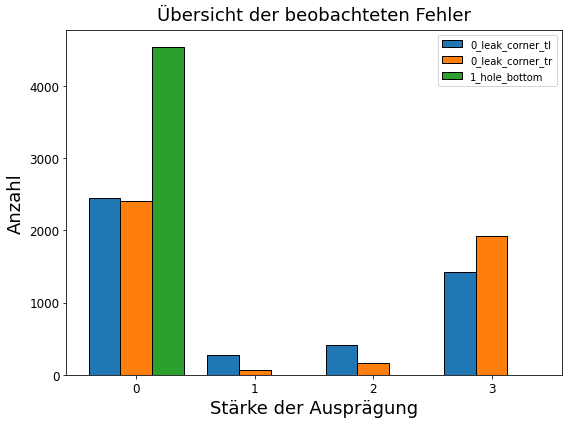

In [12]:
plotLabelHist(df["Labels"])
plt.show()

Zusammenfassend kann festgehalten werden, dass der Datensatz ca. 4500 Teile umfasst welche durch ca. 100 Merkmale beschrieben werden. Diese Merkmale ergeben sich überwiegend aus den internen Messungen der Spritzgussmaschine. Interessant sind vor Allem die Zielwerte `0_leak_corner_tl` und `0_leak_corner_tr`, welche in der Regel entweder gar nicht oder sehr stark auftreten.

## 3.4 Aufteilen der Daten
Zunächst wird der Datensatz in Trainings- und Testdaten unterteilt. Wie im vorherigen Unterkapitel gezeigt können manche Fehler sehr selten sein. Deshalb wird eine stratifizierte anstatt einer rein zufälligen Stichprobe gezogen, vgl. [3].

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df, df["Labels"]["0_leak_corner_tr"]):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]

print("Anzahl Datenpunkte:")
print("Trainingsdaten:", len(df_train))
print("Testdaten:", len(df_test))

Anzahl Datenpunkte:
Trainingsdaten: 3638
Testdaten: 910


Im nächsten Schritt werden die Merkmale und Zielwerte voneinander getrennt:

In [14]:
# Merkmale
X_train = df_train.drop("Labels", axis=1)
X_test = df_test.drop("Labels", axis=1)

# Zielwerte
y_train = df_train["Labels"].copy()
y_test = df_test["Labels"].copy()

## 3.5 Erkunden der Daten
Nun können die Trainingsdaten erkundet werden. Ein gängiges Hilfsmittel dazu ist die sog. Korrelationsmatrix. Diese enthält den Pearson-Korrelationskoeffizienten für jedes einzelne Merkmal mit jedem anderen. Um einen Überblick zu bekommen wird diese zunächst grafisch dargestellt:

In [15]:
def plotCorrMatrix(df):
    fig = plt.figure(figsize=(7, 7))

    # Korrelationsmatrix
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr())
    fig.colorbar(cax)

    # Titel und Achsenbeschriftung
    ax.set_title("Korrelationsmatrix", size=18, pad=18)
    ax.set_xlabel("Merkmale", labelpad=20)
    ax.set_ylabel("Merkmale", labelpad=20)

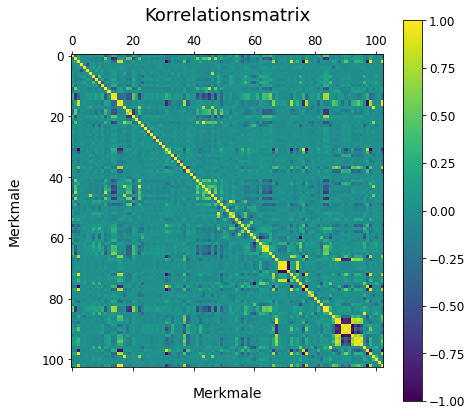

In [16]:
plotCorrMatrix(X_train)
plt.show()

In der Grafik sind sowohl stark positive (nahe *1*) als auch stark negative (nahe *-1*) Korrelationen zu erkennen. Insbesondere rechts unten sind zusammenhängende Bereiche stark korrelierender Merkmale sichtbar. Diese Beobachtungen deuten darauf hin, dass eine Dimensionsreduktion nachfolgend ein hilfreicher Zwischenschritt sein könnte.

Interessant können auch die Korrelationen der Merkmale mit den Zielwerten sein. Nachfolgend werden die am stärksten mit dem Fehler `0_leak_corner_tr` korrelierenden Merkmale aufgelistet.

In [17]:
fault_corr = df.corr()["Labels"]["0_leak_corner_tr"].sort_values(ascending=False)

# Korrelationen der Fehler untereinander entfernen
fault_corr = fault_corr.drop("Labels", level=0, axis=0)

Diese 5 Merkmale besitzen die stärkste positive Korrelation mit dem Fehler:

In [18]:
fault_corr.head(5)

Group        Name                                            
Internal_C2  Spezifischer Einspritzdruck Spitzenwert [APVs 2]    0.936937
             Einspritzarbeit [EA 2]                              0.920485
             Schussvolumen [Svo 2]                               0.857009
             Spezifischer Druck beim Umschalten [APHu 2]         0.818221
             Integral Überwachung 1 Micrograph [IDKi1_Mic 2]     0.812907
Name: 0_leak_corner_tr, dtype: float64

Diese 5 Merkmale besitzen die stärkste negative Korrelation:

In [19]:
fault_corr.tail(5)

Group        Name                                
Internal     Werkzeug 8 [Pakt 17]                   -0.373270
Internal_C2  Spritzzeit Istwert [ZSx 2]             -0.466767
             Massepolster kleinster Wert [ACPx 2]   -0.620924
             Massepolster Ende Nachdruck [ACPv 2]   -0.851165
             Massepolster nach Nachdruck [ACPn 2]   -0.857009
Name: 0_leak_corner_tr, dtype: float64

Grundsätzlich existieren stark korrelierende Merkmale (> 0,8). Diese entstammen größtenteils der Gruppe `Internal_C2`. Nachfolgend werden die Histogramme der beiden am stärksten korrelierenden Merkmale dargestellt:

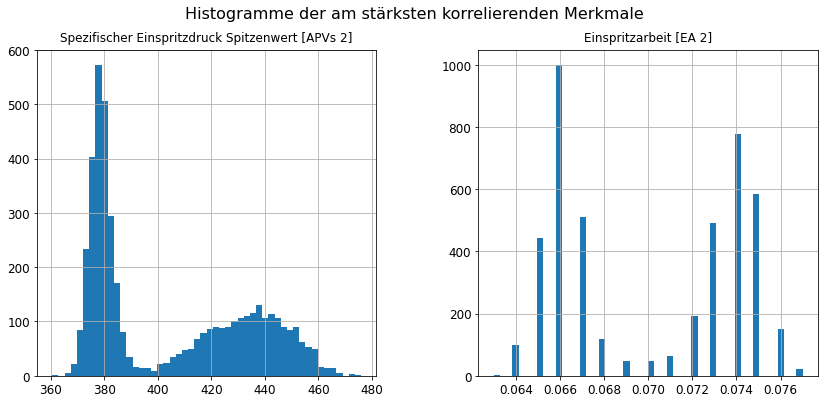

In [20]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
fig.suptitle("Histogramme der am stärksten korrelierenden Merkmale", fontsize=16)

# Histogramme
df.hist(fault_corr.index[0], bins=50, ax=axes[0])
df.hist(fault_corr.index[1], bins=50, ax=axes[1])
axes[0].set_title(fault_corr.index[0][1], pad=8)
axes[1].set_title(fault_corr.index[1][1], pad=8)

plt.show()

In beiden Histogramm sind zwei klar getrennte Cluster erkennbar. Es liegt die Vermutung nahe, dass es sich dabei um die fehlerfreien und fehlerhaften Teile handelt. Möglicherweise können diese bereits anhand eines einzigen Merkmals separiert werden. 

Das Erkunden der Daten hat gezeigt, dass relativ starke lineare Zusammenhänge im Datensatz existieren sowie Cluster erkennbar sind. Diese Erkenntnisse können nachfolgend bspw. bei der Auswahl von Algorithmen für bestimmte Probleme hilfreich sein. 

# 4\. Klassifizierung anhand eines Merkmals

Am einfachsten könnten fehlerhafte Teile mit Hilfe der vorhandenen Funktionen der Spritzgussmaschine aussortiert werden. Bei diesen Maschinen können üblicherweise Grenzwerte für einzelne interne Messwerte vorgegeben werden. Werden diese Grenzwerte über- bzw. unterschritten sortiert das sog. Handling (der "Roboterarm") das Teil automatisch aus. Das Finden passender Grenzwerte ist dabei die größte Herausforderung.

Um diese Aufgabe zu automatisieren, bietet sich der *CART* (Classification and Regression Trees)-Algorithmus an. Dieser wird genutzt um Entscheidungsbäume zu generieren. Wichtig dabei ist, dass er ausschließlich Binärbäume erzeugt. Bei jeder Abzweigungen von einem Knoten versucht der Algorithmus, den gewichteten Informationsgehalt der nachfolgenden Knoten zu maximieren. Je höher dieser Informationsgehalt, desto genauer können die Datenpunkte in der nachfolgenden Ebene klassifiziert werden, vgl. [4]. Der Algorithmus arbeitet dabei in jedem Schritt "greedy". Das bedeutet, er versucht in jedem einzelnen Schritt das optimale Ergebnis zu erzielen. Ein größerer Kontext wird nicht beachtet. Aufgrund dieser Eigenschaften (binär und "greedy") eignet sich der CART optimal für das Finden der Grenzwerte der Spritzgussmaschine.

Die Spritzgussmaschine kann ein Teil entweder aussortieren oder nicht. Folglich müssen zunächst die Zielwerte angepasst werden. Nach Rücksprache mit dem Fachpersonal werden die Fehlerausprägungen *0* und *1* als fehlerfreies sowie *2* und *3* als fehlerhaftes Teil eingestuft:

In [21]:
def convertLabelsToBinary(labels):
    labels_bin = labels.copy()
    labels_bin.replace(1, 0, inplace=True)
    labels_bin.replace(2, 3, inplace=True)

    # Zur besseren Lesbarkeit wird die Stufe 3 abschließend in 1 "umbenannt"
    labels_bin.replace(3, 1, inplace=True)

    return labels_bin

In [22]:
y_train_01 = convertLabelsToBinary(y_train)
y_test_01 = convertLabelsToBinary(y_test)

Außerdem kann der CART (wie auch die Spritzgussmaschine) nur mit numerischen Merkmalen umgehen. Die text-basierten Merkmale werden nachfolgend entfernt.

In [23]:
X_train_num = X_train.drop(X_train.select_dtypes(exclude=np.number), axis=1)
X_test_num = X_test.drop(X_train.select_dtypes(exclude=np.number), axis=1)

Da für den CART keine Skalierung der Merkmale erforderlich ist kann der Algorithmus unmittelbar trainiert werden:

In [24]:
from sklearn.tree import DecisionTreeClassifier

# max_depth = 1 da nur der beste Grenzwert gesucht ist
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_clf.fit(X_train_num, y_train_01["0_leak_corner_tr"])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Um das Ergebnis darzustellen kann das Modul `graphviz` genutzt werden:

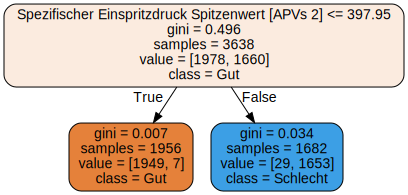

In [25]:
from sklearn.tree import export_graphviz
from graphviz import Source

# .dot-Datei exportieren
export_graphviz(
    tree_clf,
    out_file="tree_clf.dot",
    feature_names=X_train_num.droplevel(0, axis=1).columns,
    class_names=["Gut", "Schlecht"],
    rounded=True,
    filled=True,
)

# .dot-Datei in Graph umwandeln und darstellen
Source.from_file("tree_clf.dot")

Das Ergebnis sieht vielversprechend aus: In nur einem Schritt wurden zwei Gruppen gebildet, welche zu einem sehr großen Teil entweder nur aus Gut- oder nur aus Schlechtteilen bestehen. Der Informationsgehalt wurde somit stark erhöht.

An dieser Stelle offenbart sich ein weiterer großer Vorteil des CART. Bei ihm handelt es sich im Gegensatz zu vielen anderen ML-Algorithmen um einen sog. *White-Box-Algorithmus*. Das bedeutet, dass seine Entscheidungsfindung sehr einfach nachvollzogen werden kann. In diesem Fall scheint der *Spezifische Einspritzdruck Spitzenwert* entscheidend zu sein. Übersteigt dieser einen Wert von ca. 400, werden fehlerhafte Teile produziert. Hieraus könnten vom Fachpersonal weitere Erkenntnisse abgeleitet werden.

Um für die quantitative Beurteilung noch nicht auf die Testdaten zurückgreifen zu müssen wird zur Bewertung eine Kreuzvalidierung, implementiert durch die Klasse `cross_val_score`, durchgeführt. Da fehlerhafte Teile nicht selten sind kann die Genauigkeit als Bewertungskriterium genutzt werden:

In [26]:
from sklearn.model_selection import cross_val_score

tree_cv = cross_val_score(
    tree_clf, X_train_num, y_train_01["0_leak_corner_tr"], cv=10, scoring="accuracy"
)

In [27]:
def outputCVResults(cv):
    print("Genauigkeit bei der Kreuzvalidierung")
    print("- Mittelwert:", "{:.2f}".format(100 * cv.mean()), "%")
    print("- Standardabw.:", "{:.2f}".format(100 * cv.std()), "%")

In [28]:
outputCVResults(tree_cv)
results.append(("Tree_cv", 100 * tree_cv.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 98.93 %
- Standardabw.: 0.52 %


Tatsächlich lassen sich die Trainingsdaten mit einer Genauigkeit von ca. 98,9 % anhand eines einzigen Merkmals klassifizieren. Auf den Testdaten sieht das Ergebnis ähnlich aus, es scheint kein Overfitting vorzuliegen:

In [29]:
tree_cv = cross_val_score(
    tree_clf, X_test_num, y_test_01["0_leak_corner_tr"], cv=10, scoring="accuracy"
)

In [30]:
outputCVResults(tree_cv)
results.append(("Tree_test", 100 * tree_cv.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 98.90 %
- Standardabw.: 0.98 %


Diese Lösung kann weiter verbessert werden, indem auch die Grenzwerte für das 2., 3. usw. beste Merkmale ermittelt und in die Spritzgussmaschine eingetragen werden:

In [31]:
# Einstellungen
n_features = 10
label = "0_leak_corner_tr"

# Kopie der Daten erstellen da in jedem Durchlauf das "beste" Merkmal entfernt wird
X_train_cpy = X_train_num.copy()
X_test_cpy = X_test_num.copy()

# Initialisierungen
tree_clf_tmp = DecisionTreeClassifier(max_depth=1, random_state=42)
features, train_scores, test_scores = [], [], []
for _ in range(n_features):
    # Entscheidungsbaum trainieren
    tree_clf_tmp.fit(X_train_cpy, y_train_01[label])

    # Ergebnis abspeichern
    features.append(X_train_cpy.columns[tree_clf_tmp.feature_importances_.argmax()][1])
    train_scores.append(
        100
        * cross_val_score(
            tree_clf_tmp, X_train_cpy, y_train_01[label], cv=5, scoring="accuracy"
        ).mean()
    )
    test_scores.append(
        100
        * cross_val_score(
            tree_clf_tmp, X_test_cpy, y_test_01[label], cv=5, scoring="accuracy"
        ).mean()
    )

    # Bestes Merkmal für den nächsten Durchlauf entfernen
    X_train_cpy = X_train_cpy.drop(
        X_train_cpy.columns[tree_clf_tmp.feature_importances_.argmax()], axis=1
    )
    X_test_cpy = X_test_cpy.drop(
        X_test_cpy.columns[tree_clf_tmp.feature_importances_.argmax()], axis=1
    )

In [32]:
# Zur besseren Darstellung in DataFrame umwandeln
data = {"Merkmal": features, "Training [%]": train_scores, "Test [%]": test_scores}
df_features = pd.DataFrame(data)
style = df_features.style
style = style.format({"Training [%]": "{:.2f}"})
style = style.format({"Test [%]": "{:.2f}"})
style = style.background_gradient(cmap="viridis")
style = style.set_properties(**{"text-align": "right"})
style = style.set_properties(**{"text-align": "left"}, subset=["Merkmal"])
style = style.hide_index()
style

Neben dem *Spezifischen Einspritzdruck Spitzenwert* erzielen fünf weitere Merkmale eine Genauigkeit von über 95 % auf den Testdaten. Wenn das beste Merkmal nicht mehr ausreichen sollte könnten aus diesen Merkmalen zukünftig weitere Grenzwerte abgeleitet werden. Dazu muss der entsprechende Entscheidungsbaum betrachtet werden. Durch eine Verschiebung der ermittelten Grenzwerte in Richtung der Gut- bzw. Schlechtteile kann außerdem entweder die Sensitivität oder die Präzision des
tems entsprechend der spezifischen Anforderungen angepasst werden.

# 5\. Klassifizierung anhand mehrerer Merkmale

Die bei der Firma Gustav Hensel GmbH & Co. KG verwendeten Spritzgussmaschinen stellen ihre internen Messwerte unmittelbar nach Fertigstellung eines Teils über einen USB-Anschluss zur Verfügung. Dies eröffnet die Möglichkeit, auf externer Hardware einen komplexeren Klassifikator laufen zu lassen. Die Ausgabe des Klassifikators kann von den Maschinen über einen digitalen Eingang eingelesen und das gespritzte Teil bei Bedarf aussortiert werden.

Die meisten dieser "komplexeren" Klassifikatoren erfordern eine Vorverarbeitung der Daten. Deshalb wird im nachfolgenden Unterkapitel zunächst eine Pipeline zur Datenvorverarbeitung aufgebaut.

## 5.1 Pipeline
Grundsätzlich haben die Merkmale sehr unterschiedliche Wertebereiche:

In [33]:
formatForPlotting(X_train["Internal_C1"].describe()).iloc[[1, 3, 7]]

Name  Dosierleistung [iwdls_1]  ...  Zykluszeit Nachdruck [ZNach_1]
mean                  6.786638  ...                        1.995052
min                   5.990000  ...                        0.000000
max                  26.980000  ...                        2.000000

[3 rows x 20 columns]

Außerdem sind alle bis auf ein Merkmal numerisch. Das einzige text-basierte Merkmal ist dabei nicht sehr aussagekräftig, da es fast immer einen Bindestrich enthält:

In [34]:
X_train.select_dtypes(exclude=[np.number]).value_counts()

(Internal, Ausschussursache [ASU])              
-                                                   3615
3- Polster 2 zu klein  (3/2/0/0/0)                    11
3- Polster 1 zu klein  (3/1/0/0/0)                     8
4- Durchwärmungsprüfung 2 war aktiv  (4/2/0/0/0)       4
dtype: int64

Deshalb wird dieses Merkmal von der nachfolgend aufgebauten Pipeline aussortiert. 

Zunächst wird eine Pipeline für die numerischen Merkmale aufgebaut. Diese übernimmt im Wesentlichen die Skalierung der Merkmale. Der Datensatz besitzt einige Ausreißer. Aus diesem Grund wird der `StandardScaler` verwendet, welcher wesentlich robuster gegenüber Ausreißern ist als der `MinMaxScaler`.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([("scaler", StandardScaler())])

Im nächsten Schritt wird die vollständige Pipeline definiert. Diese sortiert das text-basierte Merkmal aus. Durch die Verwendung der Klasse `ColumnTransformer` können diese Merkmale zukünftig sehr einfach mit Hilfe einer eigenen Pipeline vorverarbeitet werden.

In [36]:
from sklearn.compose import ColumnTransformer

num_features = list(X_train.select_dtypes(include=[np.number]))
text_features = list(X_train.select_dtypes(exclude=[np.number]))

pipeline = ColumnTransformer(
    [("num", num_pipeline, num_features), ("text", "drop", text_features)]
)

Nun kann die Pipeline an die Trainingsdaten angepasst und anschließend auf alle Daten angewendet werden:

In [37]:
# Anpassen an die Trainingsdaten
pipeline.fit(X_train)

# Transformation der Trainings- und Testdaten
X_train_tr = pipeline.transform(X_train)
X_test_tr = pipeline.transform(X_test)

# Wiederherstellung der DataFrames
X_train_tr = pd.DataFrame(
    X_train_tr, X_train[num_features].index, X_train[num_features].columns
)
X_test_tr = pd.DataFrame(
    X_test_tr, X_test[num_features].index, X_test[num_features].columns
)

Die vorverarbeiteten Daten können im nächsten Schritt zum Trainieren der Klassifikatioren genutzt werden.

## 5.2 Klassifikatoren
Wie bereits in den vorherigen Kapitel wird stellvertretend der häufigste Fehler `0_leak_corner_tr` untersucht.

In [38]:
label = "0_leak_corner_tr"

### 5.3 Logistische Regression
In der Regel ist es sinnvoll, mit möglichst wenigen Annahmen zu starten. Deshalb wird im ersten Versuch ein lineares Modell trainiert. Dieses wird durch die Klasse `LogisticRegeression` implementiert.

In [39]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train_tr, y_train_01[label])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Auch an dieser Stelle wird wieder auf die Kreuzvalidierung mit der Genauigkeit als Bewertungskritierium zurückgegriffen, siehe Kapitel 4.

In [40]:
log_clf_cv = cross_val_score(
    log_clf, X_train_tr, y_train_01[label], cv=10, scoring="accuracy"
)

In [41]:
outputCVResults(log_clf_cv)
results.append(("Log_reg_cv", 100 * log_clf_cv.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 99.20 %
- Standardabw.: 0.48 %


Das Ergebnis ist im Durchschnitt mit *99,2 %* nur etwas besser als mit einem sehr einfachen Entscheidungsbaum mit ca. *98,9 %*.  

### 5.4 Random Forest
Möglicherweise ist ein komplexeres Modell erforderlich. Aufgrund des Erfolgs des einfachen Entscheidungsbaums wirkt ein *Random Forest*-Modell vielversprechend. Ein Random Forest besteht aus mehreren - möglichst unkorrelierten - Entscheidungsbäumen und kann sowohl für die Klassifikation als auch Regression eingesetzt werden. Die Klassifikation erfolgt durch einen Mehrheitsentscheid der einzelnen Bäume. Um unkorrelierte Entscheidungsbäume zu erhalten werden diese bspw. auf zufällig aufgewählten Teilmengen der Merkmale trainiert, vgl. [5]. In Scikit-Learn wird dieses Modell durch die Klasse `RandomForestRegressor` implementiert.

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_tr, y_train_01[label])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Wie zuvor kann nun die Kreuzvalidierung zur Bewertung genutzt werden:

In [43]:
forest_clf_cv = cross_val_score(
    forest_clf, X_train_tr, y_train_01[label], cv=10, scoring="accuracy"
)

In [44]:
outputCVResults(forest_clf_cv)
results.append(("Forest_cv", 100 * forest_clf_cv.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 99.26 %
- Standardabw.: 0.37 %


Mit *99,26 %* ist der Random Forest nur minimal besser als die Logistische Regression mit *99,20 %*. 

### 5.5 Analyse der Fehler
Dies ist ein guter Zeitpunkt um die Fehler des Modells genauer zu untersuchen. Dazu sind die "ehrlichen" Schätzungen des Klassifikators erforderlich. Das sind Schätzungen, bei denen der Klassifikator den zu klassifizierenden Datenpunkt noch nicht gesehen hat, also nicht auf diesem trainiert wurde. Auch hier bietet Scikit-Learn mit der Klasse `cross_val_predict` eine passende Implementierung, welche auf der Kreuzvalidierung aufbaut: 

In [45]:
from sklearn.model_selection import cross_val_predict

y_train_01_pred = cross_val_predict(forest_clf, X_train_tr, y_train_01[label])

Die Fehler können im nächsten Schritt als Konfusionsmatrix dargestellt werden:

In [46]:
from sklearn.metrics import confusion_matrix

print("Konfusionsmatrix")
print(confusion_matrix(y_train_01[label], y_train_01_pred))

Konfusionsmatrix
[[1952   26]
 [   6 1654]]


Die allermeisten Teile wurden entweder korrekt positiv (1952) oder korrekt negativ (1654) klassifiziert. Allerdings wurden einige fehlerfreie Teile als fehlerhaft klassifiziert (26) und ein paar fehlerhafte Teile als fehlerfrei (6). Um diese fehlerhaften Klassifizierungen zu erklären werden nachfolgend die ursprünglichen Zielwerte (0 - 3) für ein paar dieser Teile dargestellt.

Fehlerfreie Teile die als fehlerhaft klassifiziert wurden:

In [47]:
y_train[
    np.logical_and(y_train_01[label] == 0, y_train_01_pred == 1)
].sort_index().head()

Name                 0_leak_corner_tl  0_leak_corner_tr  1_hole_bottom
2021-01-11 15:10:02                 1                 1              0
2021-01-11 16:11:52                 3                 1              0
2021-01-11 16:30:29                 2                 1              0
2021-01-11 16:32:17                 3                 1              0
2021-01-11 16:41:53                 1                 1              0

Fehlerhafte Teile die als fehlerfrei klassifiziert wurden:

In [48]:
y_train[
    np.logical_and(y_train_01[label] == 1, y_train_01_pred == 0)
].sort_index().head()

Name                 0_leak_corner_tl  0_leak_corner_tr  1_hole_bottom
2021-01-11 14:53:13                 1                 2              0
2021-01-11 14:58:01                 1                 2              0
2021-01-11 16:12:29                 1                 2              0
2021-01-12 05:57:11                 1                 2              0
2021-01-12 12:55:29                 1                 2              0

In der Spalte `0_leak_corner_tr` beider Tabellen ist erkennbar, dass die falsch klassifizierten Teile mit einer Fehlerstärke von 1 bzw. 2 jeweils am Rand der binären Entscheidungsgrenze (zwischen 1 und 2) liegen. Vermutlich handelt es sich bei diesen Teilen um Grenzfälle, welche sowohl der Fehlerstärke 1 als auch 2 hätten zugeordnet werden können. Die Fotos zweier dieser Teile - dargestellt in Abbildung 4 - unterstützen diese Vermutung:

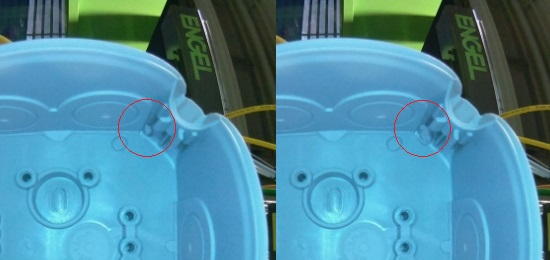

**Abbildung 4: Ein falsch positiv (links) und ein falsch negativ (rechts) klassifiziertes Teil**

Im Vergleich zu den übrigen Teilen sind beide dargestellten Fehler weder besonders schwach noch besonders stark. 

Auf Grundlage dieser Erkenntnis könnte im nächsten Schritt der Grenzwert des Klassifikators so festgelegt werden, dass dessen Sensitivität und Präzision für den vorliegenden Anwendungsfall optimal sind. Da die positive Kategorie bei diesem Datensatz nicht selten ist, bietet sich in diesem Fall die Verwendung einer ROC-Kurve an, um dieses Ziel zu erreichen, vgl. [3].

## 5.3 Zusammenfassung
Die Genauigkeit der beiden trainierten Klassifikatoren ist mit über 99,00 % bei der Kreuzvalidierung ausreichend hoch. Die fehlerhaft klassifizierten Teile liegen vermutlich nahe der binären Entscheidungsgrenze. Diese Fehler sind bei einem binären Klassifikator auf Basis analoger Merkmale zu erwarten. Abschließend werden die Klassifikatoren anhand der Testdaten überprüft:




In [49]:
print("Genauigkeit auf den Testdaten")

# Logistische Regression
log_clf_test = log_clf.score(X_test_tr, y_test_01[label])
print("- Logistische Regression:", "{:.2f}".format(100 * log_clf_test), "%")
results.append(("Log_reg_test", 100 * log_clf_test))

# Random Forest
forest_clf_test = forest_clf.score(X_test_tr, y_test_01[label])
print("- Random Forest:", "{:.2f}".format(100 * forest_clf_test), "%")
results.append(("Forest_test", 100 * forest_clf_test))

Genauigkeit auf den Testdaten
- Logistische Regression: 99.23 %
- Random Forest: 99.34 %


Auch die Genauigkeit auf den Testdaten ist mit jeweils über *99,2 %* ausreichend hoch und sehr ähnlich zur Genauigkeit bei der Kreuzvalidierung. Von einem Under- oder Overfitting ist deshalb nicht auszugehen. Aufgrund der hohen Genauigkeit und der erklärbaren Fehler wird kein zusätzlicher Aufwand in die Optimierung der Hyperparamter investiert.

Zusammenfassend hat dieses Kapitel gezeigt, dass mit Klassifikatoren auf Basis mehrerer Merkmale sehr gute Ergebnisse erzielt werden können. Der große Nachteil dabei ist, dass dafür ca. 3600 Fotos manuell gelabelt werden mussten. Im nachfolgenden Kapitel wird deshalb untersucht, ob der Ansatz des teilüberwachten Lernens genutzt werden kann, um diesen Aufwand zu minimieren.

# 6\. Teilüberwachtes Lernen

Die vorherigen Kapitel haben gezeigt, dass ML-Algorithmen mit Hilfe gelabelter Daten fehlerhafte Teile sehr gut erkennen können. Ziel dieses Kapitel ist, den Aufwand zu minimieren, um einen solchen Algorithmus zu trainieren. Dieser Aufwand besteht hauptsächlich im Labeln der Fotos. Beim Erkunden der Daten hat sich bereits gezeigt, dass diese eine Cluster-Struktur aufweisen. Ein vielversprechender Ansatz zur Minimierung des Label-Aufwands ist deshalb das *teilüberwachte Lernen*. 

Beim teilüberwachten Lernen wird nur ein geringer Teil der Datenpunkte gelabelt. Es wird versucht, dafür repräsentative Datenpunkte zu finden. Dies könnten bspw. die Mittelpunkte der beobachteten Cluster sein. Die Label der repräsentativen Datenpunkte können auch auf andere – z.B. demselben Cluster angehörige – Datenpunkte übertragen werden, bevor ein ML-Algorithmus trainiert wird, vgl. [3]. In diesem Fall soll die Auswahl der repräsentativen Datenpunkte auf Basis der beobachteten Cluster erfolgen. Wie diese erfasst werden beschreibt das nachfolgende Unterkapitel.

## 6.1 Clustering der Daten

### 6.1.1 Auswahl relevanter Merkmale
In einem hochdimensionalen Merkmalsraum sind Datenpunkte relativ weit voneinander entfernt, wodurch deren Clustering erschwert wird, vgl. [3]. Eine einfache Möglichkeit diesen Merkmalsraum zu verkleinern ist das Entfernen von Merkmalen, welche für das untersuchte Problem wenig relevant erscheinen. Dies könnte z.B. auf Grundlage von Fachwissen erfolgen. In diesem Fall eröffnet jedoch der in Kap. 5 trainierte `RandomForestClassifier` eine einfachere Möglichkeit. Dieser besitzt das Attribut `feature_importances_`, welches Aufschluss über diejenigen Merkmale gibt, welche bei seinen Entscheidungen am wichtigsten sind. Nachfolgend die 10 wichtigsten Merkmale:

In [50]:
feature_importances = forest_clf.feature_importances_
features_df = pd.DataFrame(
    feature_importances.T, X_train_tr.columns, ["Feature importance"]
)
features_df["Feature importance"].sort_values(ascending=False).head(10)

Group        Name                                            
Internal_C2  Spezifischer Einspritzdruck Spitzenwert [APVs 2]    0.135442
             Spezifischer Druck beim Umschalten [APHu 2]         0.128987
             Massepolster Ende Nachdruck [ACPv 2]                0.126340
             Schussvolumen [Svo 2]                               0.102903
             Massepolster nach Nachdruck [ACPn 2]                0.095072
             Integral Überwachung 1 Micrograph [IDKi1_Mic 2]     0.072568
             Einspritzarbeit [EA 2]                              0.068275
             Spezifischer Nachdruck Spitzenwert [APNs 2]         0.043516
Internal     Schusszähler Istwert [SZx]                          0.034663
Internal_C2  Dosierzeit Istwert [ZDx 2]                          0.028120
Name: Feature importance, dtype: float64

Noch aufschlussreicher ist ein Graph, welche die sortierten Wichtigkeiten der Merkmale über deren Indizes darstellt:

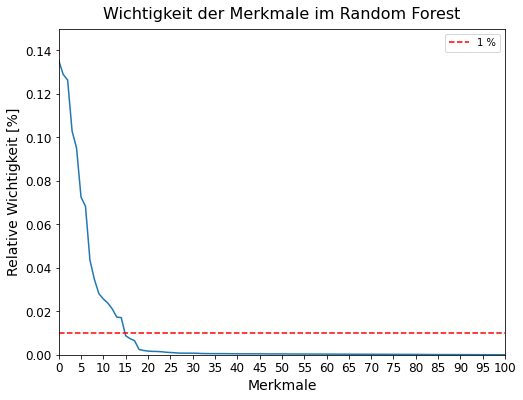

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(features_df["Feature importance"].sort_values(ascending=False).to_numpy())

# Horizontale Linie
xticks = range(0, 101, 5)
hline = 0.01
plt.plot(xticks, np.array([hline for tick in xticks]), "r--", label="1 %")

# Formatierung
plt.title("Wichtigkeit der Merkmale im Random Forest", fontsize=16, pad=10)
plt.xlabel("Merkmale")
plt.ylabel("Relative Wichtigkeit [%]")
plt.xlim(0, 100)
plt.ylim(0, 0.15)
plt.xticks(xticks)
plt.legend()
plt.show()

Der Graph zeigt, dass ca. ab dem *15. Merkmal* die relative Wichtigkeit unter 1 % sinkt. Deshalb werden nachfolgend nur die ersten 15 Merkmale betrachtet. An dieser Stelle kann selbstverständlich auch domänenspezifisches Wissen berücksichtigt werden.

In [52]:
n_features = 15
X_train_cl = X_train_tr.iloc[:, feature_importances.argsort()[-n_features:]]
X_test_cl = X_test_tr.iloc[:, feature_importances.argsort()[-n_features:]]

# Reihenfolge der Spaltennamen wiederherstellen
X_train_cl = X_train_cl.sort_index(axis=1)
X_test_cl = X_test_cl.sort_index(axis=1)

### 6.1.2 Dimensionsreduktion
Über das Entfernen der unwichtigen Merkmale hinaus kann die Dimension des Merkmalsraums weiter reduziert werden. Dies erleichtert das Clustering und ermöglicht eine visuelle Darstellung der Cluster.

Häufig wird dafür die Hauptkomponentenanalyse (Principal Component Analysis, PCA) eingesetzt. Bei dieser handelt sich um ein mathematisches Verfahren, bei dem der ursprüngliche Merkmalsraum unter Beibehaltung einer möglichst großen Varianz auf einen niedriger dimensionalen Unterraum projiziert wird, vgl. [6]. Die Dimension des Unterraums kann dabei beliebig gewählt werden.

Die Achsen des Unterraums werden als Hauptkomponenten bezeichnet und ergeben sich aus Linearkombinationen der ursprünglchen Merkmale. Beim Erkunden der Daten in Kap. 3.5 konnten starke lineare Korrelationen im Datensatz beobachtet werden. Aus diesem Grund wird nachfolgend die PCA zur Dimensionreduktion genutzt. Auch für dieses Verfahren liefert SciKit-Learn mit der Klasse `PCA` eine Implementierung. Der nach nachfolgende Programmcode reduziert die Dimension der 15 wichtigsten Merkmale auf 3: 
 

In [53]:
from sklearn.decomposition import PCA

pca_3D = PCA(n_components=3)
X3D_train = pca_3D.fit_transform(X_train_cl)
X3D_test = pca_3D.fit_transform(X_test_cl)

Die erklärte Varianz der reduzierten Daten beträgt:

In [54]:
print(
    "Anteil erklärter Varianz (3D):",
    "{:.2f}".format(100 * pca_3D.explained_variance_ratio_.sum()),
    "%",
)

Anteil erklärter Varianz (3D): 95.03 %


Bei der Reduktion *von 15 auf 3 Dimensionen* sind folglich nur ca. 5 % der Varianz verloren gegangen. Deshalb wird nachfolgend eine Reduktion auf 2 Dimensionen ausprobiert:

In [55]:
pca_2D = PCA(n_components=2)
X2D_train = pca_2D.fit_transform(X_train_cl)
X2D_test = pca_2D.fit_transform(X_test_cl)

Die erklärte Varianz beträgt in diesem Fall:

In [56]:
print(
    "Anteil erklärter Varianz (2D):",
    "{:.2f}".format(100 * pca_2D.explained_variance_ratio_.sum()),
    "%",
)

Anteil erklärter Varianz (2D): 86.50 %


Auch wenn in 2 Dimensionen mit ca. *13,5 %* deutlich mehr Informationen verloren gegangen sind ist der zweidimensionale Datensatz für das Clustering potenziell noch sehr gut geeignet. Die nachfolgenden Visualisierungen sollen bei der Auswahl der Anzahl an Dimensionen unterstützen. Zunächst wird der dreidimensionale Datensatz dargestellt.

In [57]:
from mpl_toolkits.mplot3d import Axes3D


def plotX3D(X3D, color, anomalies=None):
    # X3D bei Bedarf in np.ndarray umwandeln
    if isinstance(X3D, pd.DataFrame):
        X3D = X3D.to_numpy()

    # Initialisierung
    fig = plt.figure(figsize=(14, 11))
    ax = fig.add_subplot(111, projection="3d")

    # Über alle Fehlerausprägungen (0 - 3) iterieren
    colors = {0: "green", 1: "yellow", 2: "orange", 3: "red"}
    labels = {
        0: "kein Fehler",
        1: "schwacher Fehler",
        2: "mittlerer Fehler",
        3: "starker Fehler",
    }
    for c in np.sort(np.unique(color)):
        ax.plot(
            X3D_train[color == c, 0],
            X3D_train[color == c, 1],
            X3D_train[color == c, 2],
            ".",
            label=labels[c],
            c=colors[c],
            alpha=0.2,
        )

    # Formatierung
    ax.legend()
    ax.set_xlabel("Hauptkomponente $x_1$", fontsize=14, labelpad=10)
    ax.set_ylabel("Hauptkomponente $x_2$", fontsize=14, labelpad=10)
    ax.set_zlabel("Hauptkomponente $x_3$", fontsize=14, labelpad=10)
    ax.set_zlim(-6, 6)
    ax.view_init(50, 145)

    # Optional können Anomalien dargestellt werden
    if isinstance(anomalies, np.ndarray):
        ax.scatter(
            anomalies[:, 0], anomalies[:, 1], anomalies[:, 2], marker="x", s=80, c="red"
        )

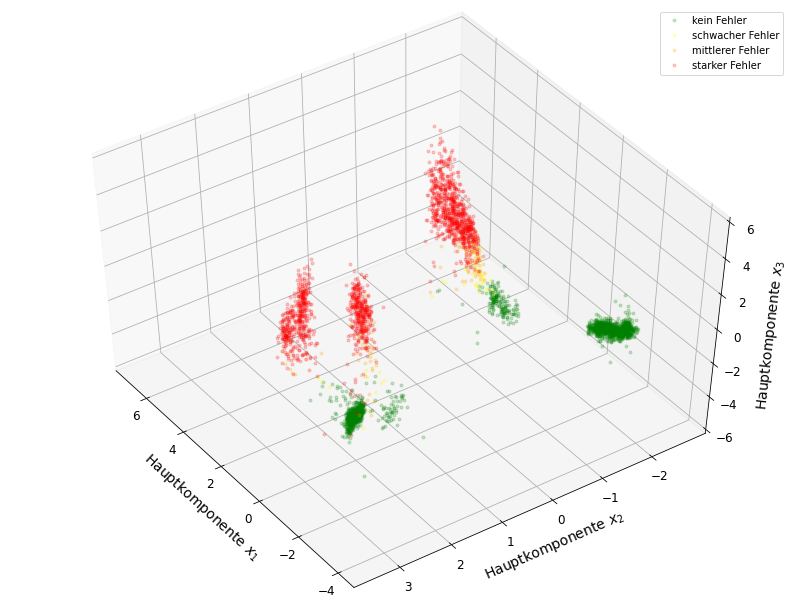

In [58]:
plotX3D(X3D_train, y_train[label])
plt.show()

Es sind eindeutig Cluster zu erkennen. Sowohl für die Gut- als auch Schlechtteile existieren mehrere Cluster. Die Cluster der Schlechtteile (rot) sind deutlich weniger kompakt und länglicher gezogen als die Cluster der Gutteile (grün). Um zu überprüfen ob diese Informationen auch im zweidimensionalen Datensatz erhalten geblieben sind wird dieser als nächstes dargestellt.

In [59]:
def plotX2D(X2D, color, anomalies=None):
    # X2D bei Bedarf in np.ndarray umwandeln
    if isinstance(X2D, pd.DataFrame):
        X2D = X2D.to_numpy()

    # Initialisierung
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    # Über alle Fehlerausprägungen (0 - 3) iterieren
    colors = {0: "green", 1: "yellow", 2: "orange", 3: "red"}
    labels = {
        0: "kein Fehler",
        1: "schwacher Fehler",
        2: "mittlerer Fehler",
        3: "starker Fehler",
    }
    for c in np.sort(np.unique(color)):
        ax.plot(
            X2D[color == c, 0],
            X2D[color == c, 1],
            ".",
            label=labels[c],
            c=colors[c],
            alpha=0.2,
        )

    # Formatierung
    ax.legend()
    ax.set_xlabel("Hauptkomponente $x_1$", fontsize=14, labelpad=10)
    ax.set_ylabel("Hauptkomponente $x_2$", fontsize=14, labelpad=10)

    # Optional können Anomalien dargestellt werden
    if isinstance(anomalies, np.ndarray):
        ax.scatter(anomalies[:, 0], anomalies[:, 1], marker="x", s=80, c="red")

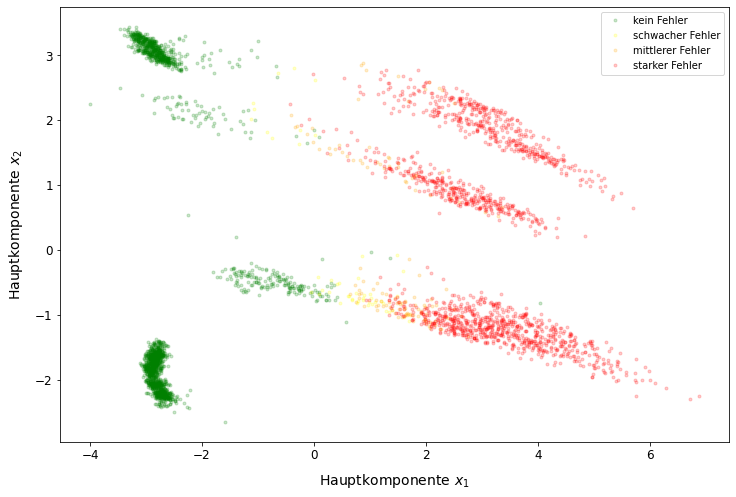

In [60]:
plotX2D(X2D_train, y_train[label])
plt.show()

Aus dieser Darstellung lassen sich sehr ähnliche Erkenntnisse ableiten wie aus der dreidimensionalen. Für das teilüberwachte Lernen wird aus Gründen der Einfachheit der zweidimensionale Datensatz verwendet.

### 6.1.3 Durchführung des Clustering
Auf Basis des zweidimensionalen Datensatz `X2D_train` kann im nächsten Schritt das Clustering durchgeführt werden. Die Darstellungen im vorherigen Unterkapitel haben gezeigt, dass die Cluster typischerweise elliptisch sind und in ihrer Dichte stark variieren können. Der Algorithmus *K-Means* kommt deshalb nicht in Frage, vgl. [3]. Stattdessen wird ein *Gaußsches Mischverteilungsmodell* (Gaussian Mixture Model, GMM) genutzt, welches diese Art von Clustern sehr gut erzeugen kann. Das Modell versucht, die Datenpunkte im Datensatz durch eine Mischung verschiedener gaußscher Verteilungen zu erzeugen, vgl. [7] Die entsprechende Klasse SciKit-Learn heißt `GaussianMixture`:

In [61]:
from sklearn.mixture import GaussianMixture

# n_components = 7 auf Grundlage der Darstellungen im vorherigen Unterkapitel
gaus_mix = GaussianMixture(n_components=7, random_state=42).fit(X2D_train)
y_pred_cluster = gaus_mix.predict(X2D_train)

Es ist hilfreich, diese Cluster darstellen zu können.

In [62]:
def plotX2DClustered(X2D, cluster, anomalies=None, cluster_centers=[]):
    # X2D bei Bedarf in np.ndarray umwandeln
    if isinstance(X2D, pd.DataFrame):
        X2D = X2D.to_numpy()

    # Initialisierung
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    # Über alle Cluster iterieren
    for c in np.sort(np.unique(cluster)):
        ax.plot(X2D[cluster == c, 0], X2D[cluster == c, 1], ".", label=c, alpha=0.2)

    # Formatierung
    ax.legend()
    ax.set_xlabel("Hauptkomponente $x_1$", fontsize=14, labelpad=10)
    ax.set_ylabel("Hauptkomponente $x_2$", fontsize=14, labelpad=10)

    # Optional können Anomalien dargestellt werden
    if isinstance(anomalies, np.ndarray):
        ax.scatter(anomalies[:, 0], anomalies[:, 1], marker="x", s=80, c="red")

    # Optional können die Zentren der Cluster dargestellt werden
    if len(cluster_centers) > 0:
        ax.plot(
            cluster_centers[:, 0],
            cluster_centers[:, 1],
            "o",
            c="red",
            markersize=8,
            markeredgecolor="black",
        )

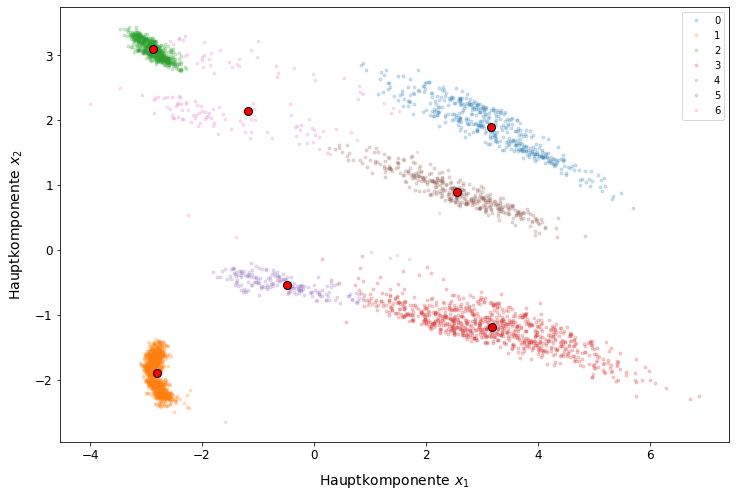

In [63]:
plotX2DClustered(X2D_train, y_pred_cluster, cluster_centers=gaus_mix.means_)

Der Algorithmus hat die Cluster sehr gut erkannt. Die jeweiligen Mittelwerte werden als roter Punkt dargestellt. Das Gaußsche Mischverteilungsmodell wird nachfolgend die Grundlage für das teilüberwachte Lernen bilden.


## 6.2 Durchführung des teilüberwachten Lernens
Auf Basis des Clustering kann nun der Einfluss des teilüberwachten Lernens auf die Genauigkeit eines Klassifikators ermittelt werden. Stellvertretend wird nachfolgend der Klassifikator `LogisticRegression` eingesetzt, welcher in Kap. 5.3 bereits eine Genauigkeit von ca. *99,0 %* auf dem gesamten Datensatz erreicht hat.

### 6.2.1 Referenz
Für den späteren Vergleich ist zunächst eine Referenzgenauigkeit mit allen Labeln zu ermitteln:

In [64]:
from sklearn.linear_model import LogisticRegression

log_clf_full = LogisticRegression(random_state=42)
log_clf_full.fit(X2D_train, y_train_01[label])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Um noch nicht auf die Testdaten zurückgreifen zu müssen wird zur Bewertung eine Kreuzvalidierung durchgeführt:

In [65]:
from sklearn.model_selection import cross_val_score

log_full_cv = cross_val_score(
    log_clf_full, X2D_train, y_train_01[label], cv=10, scoring="accuracy"
)

In [66]:
def outputResults(scores):
    print("Genauigkeit bei der Kreuzvalidierung")
    print("- Mittelwert:", "{:.2f}".format(100 * scores.mean()), "%")
    print("- Standardabw.:", "{:.2f}".format(100 * scores.std()), "%")
    print("- 10. Perzentil:", "{:.2f}".format(100 * np.percentile(scores, 10), "%"))

In [67]:
outputResults(log_full_cv)
results.append(("Log_reg_full_cv", 100 * log_full_cv.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 98.82 %
- Standardabw.: 0.51 %
- 10. Perzentil: 98.04


Interessanterweise hat dieser Klassifikator mit ca. *98,8 %* auf dem zweidimensionalen Datensatz eine quasi identische Genauigkeit wie auf dem gesamten Datensatz mit über 100 Merkmalen.

Eine weitere Referenz ist die Genauigkeit mit rein zufällig ausgewählten Datenpunkten. Um diese zu ermitteln werden nachfolgend mehrfach Datenpunkte zufällig ausgewählt, das Modell mit ihnen trainiert und abschließend anhand der gesamten Trainingsdaten bewertet.

In [68]:
n_labeled = 10

In [69]:
def randomSemisupervisedLearning(X, y, n_labeled, runs=1000):
    scores = []

    # Initialisierung des Klassifikators
    clf = LogisticRegression(random_state=42)

    for i in range(runs):
        # Auswahl zufälliger Datenpunkte
        idx_rnd = pd.DataFrame(X).sample(n=n_labeled, random_state=i).index

        # Kontrolle ob sowohl Gut- als auch Schlechtteile ausgewählt wurden
        if y[idx_rnd].nunique() > 1:
            # Trainieren des Modells
            clf.fit(pd.DataFrame(X).iloc[idx_rnd], y.iloc[idx_rnd])

            # Genauigkeit des Modells abspeichern
            scores.append(clf.score(pd.DataFrame(X), y))

    outputResults(np.array(scores))
    return np.array(scores)

In [70]:
scores = randomSemisupervisedLearning(X2D_train, y_train_01[label], n_labeled=n_labeled)
results.append(("Log_reg_rnd", 100 * scores.mean()))

Genauigkeit bei der Kreuzvalidierung
- Mittelwert: 97.40 %
- Standardabw.: 2.46 %
- 10. Perzentil: 95.93


Auch mit nur 10 zufällig ausgewählten Datenpunkten erreicht der Klassifikator im Durchschnitt eine Genauigkeit von immerhin *97,4 %*. Allerdings liegen 10 % der Klassifikatoren mit ihrer Genauigkeit unter 96,0 %. Folglich ist das Ziel des nachfolgenden Kapitels, mit 10 repräsentativ ausgewählten Datenpunkten eine Genauigkeit von min. 97,4 % und im Idealfall 99,0 % zu erreichen.

### 6.2.2 Auswahl durch Clustering
Nun kann das teilüberwachte Lernen durchgeführt werden. Zunächst werden durch den Clustering-Algorithmus die Cluster und deren Mittelpunkte bestimmt:

In [71]:
from sklearn.mixture import GaussianMixture

# Genauso viele Cluster wie Datenpunkte gelabelt werden sollen
gaus_mix = GaussianMixture(n_components=n_labeled, random_state=42)
gaus_mix.fit(X2D_train)
y_pred_cluster = gaus_mix.predict(X2D_train)

Als nächstes werden die Datenpunkte ausgewählt, welche den Mittelpunkten der Cluster am nächsten liegen:

In [72]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(gaus_mix.means_, X2D_train)
X2D_train_repr = X2D_train[closest]

Das Ergebnis stellt die nachfolgende Abbildung dar. Die gefundenen Datenpunkte sind als rote Punkte eingezeichnet:

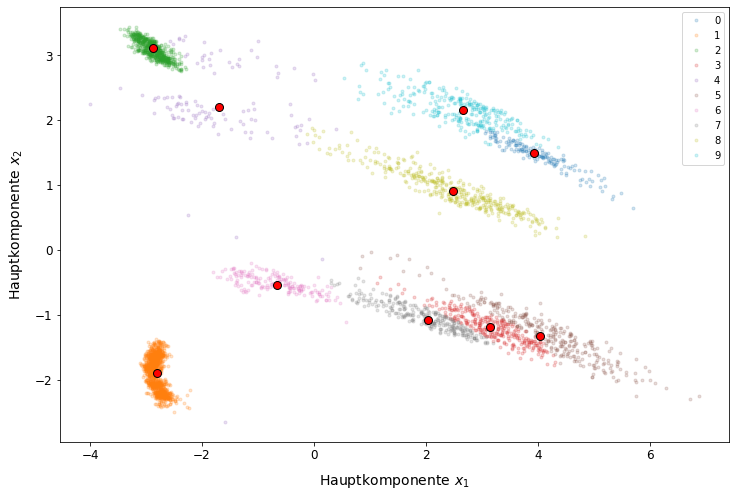

In [73]:
plotX2DClustered(X2D_train, y_pred_cluster, cluster_centers=X2D_train_repr)
plt.show()

Im nächsten Schritt kann der Klassifikator mit diesen Datenpunkten trainiert und ausgewertet werden.

In [74]:
log_clf_repr = LogisticRegression(random_state=42)
log_clf_repr.fit(X2D_train[closest], y_train_01[label].iloc[closest])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
print("Genauigkeit nach Auswahl durch Clustering")
print("-", "{:.2f}".format(100 * log_clf_repr.score(X2D_train, y_train_01[label])), "%")
results.append(("Log_reg_repr", 100 * log_clf_repr.score(X2D_train, y_train_01[label])))

Genauigkeit nach Auswahl durch Clustering
- 98.52 %


Das Ergebnis ist mit *98,5 %* deutlich besser als bei der rein zufälligen Auswahl mit *97,4 %*, erreicht jedoch nicht die 99,0 %. Ein Propagieren der repräsentativen Label auf die anderen Datenpunkte im Cluster könnte eine weitere Verbesserung bringen:

In [76]:
y_train_01_prop = np.empty(len(y_train_01), dtype=np.int32)
for c in range(n_labeled):
    y_train_01_prop[y_pred_cluster == c] = y_train_01[label].iloc[closest][c]

Die aus den 10 repräsentativen Datenpunkten für den gesamten Datensatz abgeleiteten Label zeigt die nachfolgende Abbildung:

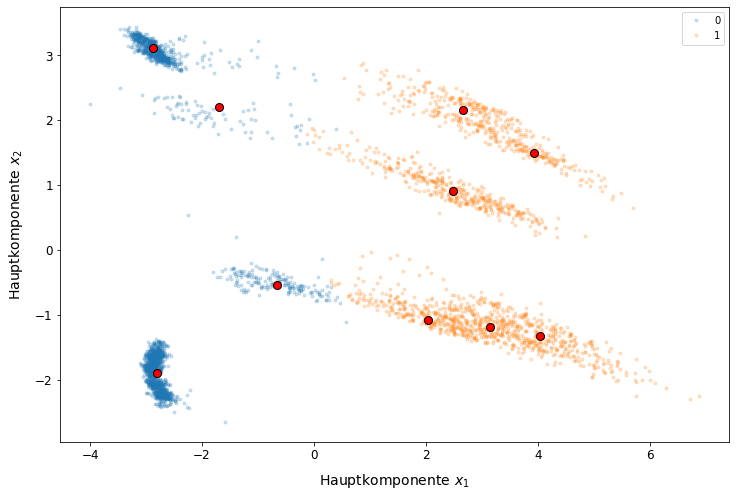

In [77]:
plotX2DClustered(X2D_train, y_train_01_prop, cluster_centers=X2D_train_repr)

Nun kann erneut ein Klassifikator trainiert und ausgewertet werden:

In [78]:
log_clf_prop = LogisticRegression(random_state=42)
log_clf_prop.fit(X2D_train, y_train_01_prop)

print("Genauigkeit nach Auswahl durch Clustering und Propagieren")
print("-", "{:.2f}".format(100 * log_clf_prop.score(X2D_train, y_train_01[label])), "%")
results.append(("Log_reg_prop", 100 * log_clf_prop.score(X2D_train, y_train_01[label])))

Genauigkeit nach Auswahl durch Clustering und Propagieren
- 98.65 %


Das Propagieren hat eine geringfügige Verbesserung auf *98,65 %* gebracht, was nun beinahe der Referenz von *98,82 %* entspricht. Abschließend wird dieses Ergebnis anhand der Testdaten überprüft:

In [79]:
print("Genauigkeit auf den Testdaten")
print(
    "- Überwachtes Lernen:",
    "{:.2f}".format(100 * log_clf_full.score(X2D_test, y_test_01[label])),
    "%",
)
print(
    "- Teilüberwachtes Lernen:",
    "{:.2f}".format(100 * log_clf_prop.score(X2D_test, y_test_01[label])),
    "%",
)

results.append(
    ("Log_reg_prop_test", 100 * log_clf_prop.score(X2D_test, y_test_01[label]))
)

Genauigkeit auf den Testdaten
- Überwachtes Lernen: 98.79 %
- Teilüberwachtes Lernen: 98.57 %


Die Genauigkeit auf den Testdaten ist beim überwachten und teilüberwachten ähnlich hoch und mit jeweils über 98,5 % ausreichend. Grundsätzlich stellt das teilüberwachte Lernen somit einen vielversprechenden Ansatz für Aufgaben dieser Art dar, denn in diesem Fall musste nur ca. 0,3 % (10 / 3600) des ursprünglichen Aufwands für das Labeln investiert werden.

### 6.2.3 Analyse der Fehler
Abschließend werden die Teile analysiert, welche beim Propagieren innerhalb der Cluster ein falsches Label erhalten haben:

In [80]:
false_pos = np.logical_and(y_train_01[label] == 0, y_train_01_prop == 1)
false_neg = np.logical_and(y_train_01[label] == 1, y_train_01_prop == 0)

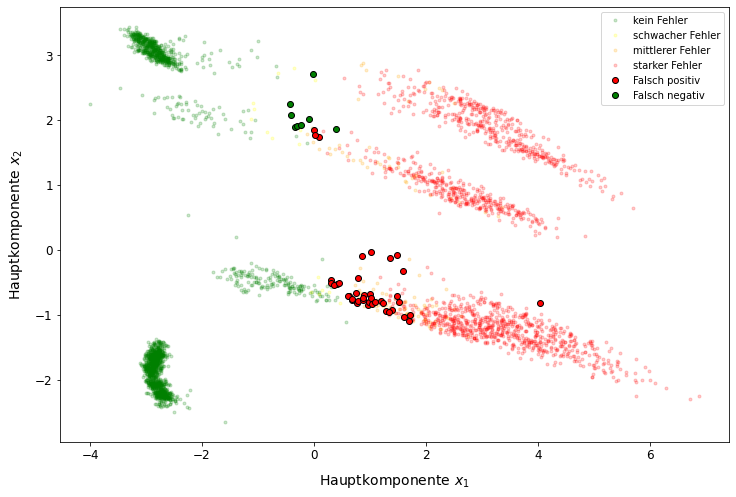

In [81]:
plotX2D(X2D_train, y_train[label])

# Falsch positiv bzw. negativ klassifizierte Datenpunkte darstellen
plt.plot(
    X2D_train[false_pos][:, 0],
    X2D_train[false_pos][:, 1],
    "o",
    c="red",
    markeredgecolor="black",
    label="Falsch positiv",
)
plt.plot(
    X2D_train[false_neg][:, 0],
    X2D_train[false_neg][:, 1],
    "o",
    c="green",
    markeredgecolor="black",
    label="Falsch negativ",
)

plt.legend()
plt.show()

In der Abbildung sind als schwarz umrandete Punkte diejenigen Teile markiert, welche beim propagieren der repräsentativen Label ein falsches Label erhalten haben. Falsch positive Teile sind dabei rot, falsch negative Teile grün ausgefüllt. Grundsätzliche liegen diese Teile wie erwartet im Grenzbereich zwischen Gut- und Schlechtteilen. Auf den ersten Blick wirkt die dargestellte Klassifizierung nachvollziehbar. Bspw. erscheint es sinnvoll, dass das große Cluster der falsch positiven Teile (untere Hälfte der Abbildung) scheinbar dem rechten unteren Cluster an Fehlteilen zugeordnet wurde. Interessant ist das originale Label (0 - 3) dieser falsch klassifizierten Teile:

In [82]:
print("Ursprüngliches Label der falsch positiven Klassifizierungen")
print(y_train[label][false_pos].value_counts())

Ursprüngliches Label der falsch positiven Klassifizierungen
1    34
0     7
Name: 0_leak_corner_tr, dtype: int64


Die meisten dieser Teile hatten einen leichten Fehler (Stufe 1). Es ist nachvollziehbar, dass diese ähnlich wie die anderen Fehlteile (Stufe 2 und 3) eingeschätzt wurden. Teile mit einem leichten Fehler unterscheiden sich grundsätzlich von den vollständig fehlerfreien Teilen. Dies deuten auch die Cluster in der Abbildung an. Nachfolgend wird der Klassifikator aus dem teilüberwachten nochmal ausgewertet, diesmal werden jedoch auch leichte Fehler der positiven Kategorie zugeordnet:

In [83]:
y_train_01_alt = y_train.copy()
y_train_01_alt.replace(1, 1, inplace=True)
y_train_01_alt.replace(2, 1, inplace=True)
y_train_01_alt.replace(3, 1, inplace=True)

In [84]:
print("Genauigkeit mit alternativem Label:")
print(
    "-",
    "{:.2f}".format(100 * log_clf_prop.score(X2D_train, y_train_01_alt[label])),
    "%",
)
results.append(
    ("Log_reg_prop_1-3", 100 * log_clf_prop.score(X2D_train, y_train_01_alt[label]))
)

Genauigkeit mit alternativem Label:
- 99.15 %


Auf den Testdaten ist das Ergebnis ebenfalls besser:

In [85]:
y_test_01_alt = y_test.copy()
y_test_01_alt.replace(1, 1, inplace=True)
y_test_01_alt.replace(2, 1, inplace=True)
y_test_01_alt.replace(3, 1, inplace=True)

In [86]:
print("Genauigkeit mit alternativem Label:")
print(
    "-", "{:.2f}".format(100 * log_clf_prop.score(X2D_test, y_test_01_alt[label])), "%"
)
results.append(
    ("Log_reg_prop_1-3_test", 100 * log_clf_prop.score(X2D_test, y_test_01_alt[label]))
)

Genauigkeit mit alternativem Label:
- 98.90 %


Je nach Problemstellung sollte somit gut abgewogen werden, ob bei einer binären Klassifikation Teile mit einem leichten Fehler als fehlerfrei oder fehlerhaft eingestuft werden.

# 7\. Ergebnisse und Evaluation

Abschließend können die Ergebnisse zusammengefasst und kritisch bewertet werden. Dazu werden nachfolgend die Genauigkeiten der im Rahmen dieser Arbeit trainierten Klassifikatoren dargestellt:

In [87]:
# Für die Darstellung in DataFrame umwandeln
results_data = {
    "Klassifikator": np.array(results)[:, 0],
    "Genauigkeit [%]": np.array(results)[:, 1].astype(float),
}
results_df = pd.DataFrame(results_data).set_index("Klassifikator")

# Spalte für das Ergebnis auf den Testdaten hinzufügen
results_test = results_df[results_df.index.str.contains("_test")]
results_test.index = results_test.index.str.replace("_test", "")
results_test.columns = ["Test [%]"]

# Spalte für das Ergebnis auf den Trainingsdaten anpassen
results_training = results_df[np.invert(results_df.index.str.contains("_test"))]
results_training.index = results_training.index.str.replace("_cv", "")
results_training.columns = ["Training [%]"]

# Spalten kombinieren
results_df = pd.concat([results_training, results_test], axis=1)
results_df = results_df.reset_index()
results_df = results_df.rename(columns={"index": "Klassifikator"})

# Formatierung
style = results_df.style
style = style.format({"Test [%]": "{:.1f}"})
style = style.format({"Training [%]": "{:.1f}"})
style = style.set_properties(**{"text-align": "left"})
style = style.set_properties(**{"text-align": "right"}, subset=["Test [%]"])
style = style.set_properties(**{"text-align": "right"}, subset=["Training [%]"])
style = style.background_gradient(cmap="plasma", subset=["Training [%]"])
style = style.hide_index()
style

Die Genauigkeit auf den Trainingsdaten wurde mittels Kreuzvalidierung bestimmt und ist deshalb stets ähnlich hoch wie die Genauigkeit auf den Testdaten. Grundsätzlich erreichen alle Klassifikatoren mit über 97,0 % eine relativ hohe Genauigkeit. Die untersuchten Fehler lassen sich sehr gut durch ML-Algorithmen erkennen.

Bereits ein Entscheidungsbaum (`Tree`, Kap. 4) erreicht mit einer einzigen Aufteilung eine Genauigkeit von 98,9 % auf den Testdaten. Mit Hilfe logistischer Regression (`Log_reg`, Kap. 5.3) bzw. eines Random Forests (`Forest`, Kap. 5.4) lässt sich diese Genauigkeit auf über 99,2 % steigern. Problematisch waren dabei vor allen diejenigen Teile, welche sich am Rand der binären Entscheidungsgrenze zwichen Gut- und Schlechtteil befanden.

In Kap. 6.1 hat sich gezeigt, dass sich die Dimension des Merkmalsraums für diesen Datensatz unter Beibehaltung eines Großteils seiner Varianz auf zwei oder drei reduzieren lässt. Auch in diesem reduzierten Merkmalsraum erzielte die logistische Regression (`Log_reg_full`) noch eine Genauigkeit von 98,8 %. Mit Hilfe eines Gaußschen Mischverteilungsmodells ließen sich anschließend die zuvor beobachteten Cluster gut erkennen und für das teilüberwachte Lernen nutzen.

Das Kapitel 6.2 zum teilüberwachten Lernen hat gezeigt, dass es für diese Art von Daten nicht notwendig ist, sämtliche Datenpunkte zu labeln. So erreicht eine logistische Regression, welche auf 10 zufällig ausgewählten Datenpunkten trainiert wurde (`Log_reg_rnd`) im Mittel eine Genauigkeit von 97,4 %. Werden auf Basis der erkannten Cluster 10 repräsentative Datenpunkte gelabelt (`Log_reg_repr`), steigt diese Genauigkeit auf 98,2 %. Ein Propagieren der Label auf alle weiteren Datenpunkte im jeweiligen Cluster (`Log_reg_prop`) erhöhte die Genauigkeit weiter auf 98,6 %. Dieses Ergebnis liegt nur noch minimal unter den Ergebnissen der auf dem gesamten Datensatz trainierten Klassifikatoren.

Zusammenfassend kann festgehalten werden, dass sich die untersuchten Fehler durch teilüberwachtes Lernen mit einem sehr geringen Aufwand und einer dennoch sehr hohen Genauigkeit von über 98,5 % erkennen lassen. Dafür waren relativ einfache lineare Machine-Learning-Modelle ausreichend.

Die Untersuchung hat jedoch auch gezeigt, dass sowohl mehrere Cluster mit Gut- als auch mit Schlechtteilen entstehen können. Es ist ungewiss, ob auch komplett neue Cluster den Regeln folgen, welche die im Rahmen dieser Arbeit trainierten Algorithmen gelernet haben. Allerdings stellt auch bei diesem Problem das teilüberwachte Lernen einen vielversprechenden Lösungsansatz dar. 

Ungewiss ist ebenfalls, wie gut sich diese Vorgehensweise auf andere Fehler übertragen lässt. Die untersuchten Fehler traten relativ häufig und in Clustern auf. Seltene Fehler, welche darüber hinaus sehr stark verstreut sind, würden vom Clustering und damit vom teilüberwachten Lernen nicht möglicherweise nicht erfasst. Ein Beispiel ist der Fehler `1_hole_bottom` im Datensatz, welcher nur ein paar Mal aufgetreten ist.


Eine Herausforderung für den beschriebenen Lösungsansatz wäre es außerdem, wenn ein neuer Datensatz sich nicht auf relativ wenige Dimensionen reduzieren lässt, ohne einen zu großen Anteil seiner Varianz zu verlieren. Die resultierende geringe Dichte an Datenpunkten im Merkmalsraum könnte das Clustering erschweren. Zu demselben Problem würde eine zu geringe Anzahl an Datenpunkten führen. Dies ist im Spritzguss jedoch in der Regel kein Problem.

# 8\. Ausblick

Grundsätzlich bildet diese Arbeit die Grundlage für eine Vielzahl möglicher Weiterentwicklungen. Mit einem System, welches die Prozessdaten regelmäßig auf neue Cluster untersucht und Fotos repräsentativer Teile zur Beurteilung an das Fachpersonal schickt, könnte der in dieser Arbeit beschriebenen Lösungsansatz in die Praxis überführt werden. Dabei könnten auch Aspekte des *aktiven Lernens* berücksichtigt werden. Im Zuge dessen könnte das System ebenfalls auf weitere Fehlertypen und Produkte übertragen werden. Es sind jedoch die in der kritischen Auseinandersetzung beschriebenen Aspekte zu berücksichtigen.

In der kritischen Auseinandersetzung wurde ebenfalls das Problem angesprochen, dass andere Fehlertypen selten und weit verstreut sein könnten. Um auch diese zu erkennen könnte die erarbeitete Lösung um eine Anomalieerkennung ergänzt werden. Das bereits implementierte Clustering mittels Gaußschem Mischverteilungsmodell bietet durch die bereitgestellten Wahrscheinlichkeitsdichtefunktionen eine sehr gute Grundlage dafür.

Des Weiteren könnten Zeitreihenanalysen auf dem vorliegenden Datensatz durchgeführt werden, um den Ursprung der Fehler zu finden und diese gar nicht erst entstehen zu lassen.

# Literaturverzeichnis

[1] L. Schauerte, *Vorstudie zum Potenzial des Data Mining im Spritzguss zur
Verringerung von Produktionsfehlern*, 2021

[2] Gustav Hensel GmbH & Co. KG, Available: https://www.hensel-electric.de, 2021

[3] Aurélien Géron, *Praxiseinstieg Machine Learning mit Scikit-Learn und TensorFlow*, 2018, O'Reilly Verlag

[4] L. Breiman, J. H. Friedman, R. A. Olshen, C. J. Stone: *CART: Classification and Regression Trees*, 1984.

[5] L. Breiman, *Random forests. In: Machine Learning*, 2001, Seite 5–32

[6] G. H. Dunteman: *Principal Component Analysis*, 1989, Sage Publications

[7] Ch. Fraley, A. Raftery, *Normal Mixture Modeling and Model-Based Clustering*, 2015


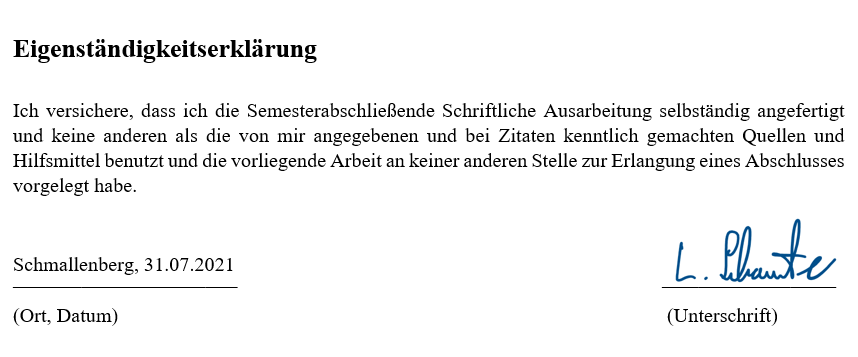